In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
import time

from model.nets import Siren
from model.flow import PipeFlow
from model.sampler import CylinderSampler

In [2]:
Wo = 5
Pn = [  complex(-0.5060,0.1245),
        complex(0.0802,0.0886),
        complex(0.0591,0.0251),
        complex(0.0228,0.0244),
        complex(0.0141,0.0071),
        complex(0.0112,0.0107),
        complex(0.0065,0.0056),
        complex(0.0067,0.0050),
        complex(0.0030,0.0040),
        complex(0.0044,0.0030),
        complex(0.0000,0.3710),
        complex(0.1493,0.0754),
        complex(0.0161,0.0103),
        complex(0.0166,0.0082),
        complex(-0.0002,0.0046),
        complex(0.0063,0.0001),
        complex(0.0008,0.0013),
        complex(0.0021,-0.0012),
        complex(0.0009,0.0015),
        complex(0.0001,-0.0001)]
pipe = PipeFlow(Po=-0.20,Pn=Pn,Wo=Wo)
staticPipe = PipeFlow(Po=-0.20,Wo=Wo)

In [3]:
net = Siren(in_features=4, out_features=4, hidden_features=256, 
                  hidden_layers=5, outermost_linear=True)
net.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=4, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): Linear(in_features=256, out_features=4, bias=True)
  )
)

In [4]:
# Sampler
sampler = CylinderSampler(R=1,L=8,T=1,Np=2**13)

In [5]:
# Helper Functions
def fields(X,net):
    # Fields
    F = net(X)
    u = F[:,0]
    v = F[:,1]
    w = F[:,2]
    p = F[:,3]
    
    return u,v,w,p

def velocity(X,net,split=False):
    F = net(X)
    
    u = F[:,0]
    v = F[:,1]
    w = F[:,2]
    
    U = F[:,0:3]
    
    if not split:
        return U
    else:
        return u,v,w

def velocityGradient(X,net,vec=None):
    dudx = net.jacobian(X,0,0)
    dudy = net.jacobian(X,0,1)
    dudz = net.jacobian(X,0,2)
    
    dvdx = net.jacobian(X,1,0)
    dvdy = net.jacobian(X,1,1)
    dvdz = net.jacobian(X,1,2)
    
    dwdx = net.jacobian(X,2,0)
    dwdy = net.jacobian(X,2,1)
    dwdz = net.jacobian(X,2,2)
    
    if not vec == None:
        Du = (dudx*vec[:,0] + dudy*vec[:,1] + dudz*vec[:,2]).reshape((X.size()[0],1))
        Dv = (dvdx*vec[:,0] + dvdy*vec[:,1] + dvdz*vec[:,2]).reshape((X.size()[0],1))
        Dw = (dwdx*vec[:,0] + dwdy*vec[:,1] + dwdz*vec[:,2]).reshape((X.size()[0],1))
        
        return torch.cat((Du,Dv,Dw),1)
    else:
        return dudx,dudy,dudz,dvdx,dvdy,dvdz,dwdx,dwdy,dwdz

def pressureGradient(X,net,vec=None):
    dpdx = net.jacobian(X,3,0)
    dpdy = net.jacobian(X,3,1)
    dpdz = net.jacobian(X,3,2)
    
    if not vec == None:
        return dpdx*vec[:,0] + dpdy*vec[:,1] + dpdz*vec[:,2]
    else:
        return dpdx, dpdy, dpdz
    
def velocityTimeDeriv(X,net):
    dudt = net.jacobian(X,0,3)
    dvdt = net.jacobian(X,1,3)
    dwdt = net.jacobian(X,2,3)
    
    return dudt, dvdt, dwdt

def velocity2ndDeriv(X,net):
    d2udx2 = net.hessian(X,0,0,0)
    d2udy2 = net.hessian(X,0,1,1)
    d2udz2 = net.hessian(X,0,2,2)
    
    d2vdx2 = net.hessian(X,1,0,0)
    d2vdy2 = net.hessian(X,1,1,1)
    d2vdz2 = net.hessian(X,1,2,2)
    
    d2wdx2 = net.hessian(X,2,0,0)
    d2wdy2 = net.hessian(X,2,1,1)
    d2wdz2 = net.hessian(X,2,2,2)
    
    return d2udx2,d2udy2,d2udz2,d2vdx2,d2vdy2,d2vdz2,d2wdx2,d2wdy2,d2wdz2

def momentum(X,net,Wo):
    u,v,w = velocity(X,net,split=True)
    dpdx,dpdy,dpdz = pressureGradient(X,net)
    dudx,dudy,dudz,dvdx,dvdy,dvdz,dwdx,dwdy,dwdz = velocityGradient(X,net)
    dudt,dvdt,dwdt = velocityTimeDeriv(X,net)
    d2udx2,d2udy2,d2udz2,d2vdx2,d2vdy2,d2vdz2,d2wdx2,d2wdy2,d2wdz2 = velocity2ndDeriv(X,net)
    
    mmx = dudt + u*dudx + v*dudy + w*dudz + dpdx - 1/Wo**2*(d2udx2 + d2udy2 + d2udz2)
    mmy = dvdt + u*dvdx + v*dvdy + w*dvdz + dpdy - 1/Wo**2*(d2vdx2 + d2vdy2 + d2vdz2)
    mmz = dwdt + u*dwdx + v*dwdy + w*dwdz + dpdz - 1/Wo**2*(d2wdx2 + d2wdy2 + d2wdz2)
    
    return mmx,mmy,mmz

def continuity(X,net):
    dudx,_,_,_,dvdy,_,_,_,dwdz = velocityGradient(X,net)
    
    return dudx + dvdy + dwdz

    

In [6]:
optim = torch.optim.Adam(lr=1e-4, params=net.parameters())

writer = SummaryWriter('pipe_pdesolve/run-'+str(np.round(time.time())))

overstep = 0

In [7]:
n_init = 3000
n_steps = 6000

In [8]:
# Initialize
for step in range(n_init):
    
    overstep += 1
        
    Xintr = sampler.interior(2**16)

    loss = ((net(Xintr)-staticPipe.fields(Xintr))**2).mean()

    writer.add_scalar('Initialization Loss',
                        loss.item(),
                        overstep)

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print("Initialization Step: " + str(step))

Initialization Step: 0
Initialization Step: 1
Initialization Step: 2
Initialization Step: 3
Initialization Step: 4
Initialization Step: 5
Initialization Step: 6
Initialization Step: 7
Initialization Step: 8
Initialization Step: 9
Initialization Step: 10
Initialization Step: 11
Initialization Step: 12
Initialization Step: 13
Initialization Step: 14
Initialization Step: 15
Initialization Step: 16
Initialization Step: 17
Initialization Step: 18
Initialization Step: 19
Initialization Step: 20
Initialization Step: 21
Initialization Step: 22
Initialization Step: 23
Initialization Step: 24
Initialization Step: 25
Initialization Step: 26
Initialization Step: 27
Initialization Step: 28
Initialization Step: 29
Initialization Step: 30
Initialization Step: 31
Initialization Step: 32
Initialization Step: 33
Initialization Step: 34
Initialization Step: 35
Initialization Step: 36
Initialization Step: 37
Initialization Step: 38
Initialization Step: 39
Initialization Step: 40
Initialization Step: 41
In

Initialization Step: 337
Initialization Step: 338
Initialization Step: 339
Initialization Step: 340
Initialization Step: 341
Initialization Step: 342
Initialization Step: 343
Initialization Step: 344
Initialization Step: 345
Initialization Step: 346
Initialization Step: 347
Initialization Step: 348
Initialization Step: 349
Initialization Step: 350
Initialization Step: 351
Initialization Step: 352
Initialization Step: 353
Initialization Step: 354
Initialization Step: 355
Initialization Step: 356
Initialization Step: 357
Initialization Step: 358
Initialization Step: 359
Initialization Step: 360
Initialization Step: 361
Initialization Step: 362
Initialization Step: 363
Initialization Step: 364
Initialization Step: 365
Initialization Step: 366
Initialization Step: 367
Initialization Step: 368
Initialization Step: 369
Initialization Step: 370
Initialization Step: 371
Initialization Step: 372
Initialization Step: 373
Initialization Step: 374
Initialization Step: 375
Initialization Step: 376


Initialization Step: 668
Initialization Step: 669
Initialization Step: 670
Initialization Step: 671
Initialization Step: 672
Initialization Step: 673
Initialization Step: 674
Initialization Step: 675
Initialization Step: 676
Initialization Step: 677
Initialization Step: 678
Initialization Step: 679
Initialization Step: 680
Initialization Step: 681
Initialization Step: 682
Initialization Step: 683
Initialization Step: 684
Initialization Step: 685
Initialization Step: 686
Initialization Step: 687
Initialization Step: 688
Initialization Step: 689
Initialization Step: 690
Initialization Step: 691
Initialization Step: 692
Initialization Step: 693
Initialization Step: 694
Initialization Step: 695
Initialization Step: 696
Initialization Step: 697
Initialization Step: 698
Initialization Step: 699
Initialization Step: 700
Initialization Step: 701
Initialization Step: 702
Initialization Step: 703
Initialization Step: 704
Initialization Step: 705
Initialization Step: 706
Initialization Step: 707


Initialization Step: 1000
Initialization Step: 1001
Initialization Step: 1002
Initialization Step: 1003
Initialization Step: 1004
Initialization Step: 1005
Initialization Step: 1006
Initialization Step: 1007
Initialization Step: 1008
Initialization Step: 1009
Initialization Step: 1010
Initialization Step: 1011
Initialization Step: 1012
Initialization Step: 1013
Initialization Step: 1014
Initialization Step: 1015
Initialization Step: 1016
Initialization Step: 1017
Initialization Step: 1018
Initialization Step: 1019
Initialization Step: 1020
Initialization Step: 1021
Initialization Step: 1022
Initialization Step: 1023
Initialization Step: 1024
Initialization Step: 1025
Initialization Step: 1026
Initialization Step: 1027
Initialization Step: 1028
Initialization Step: 1029
Initialization Step: 1030
Initialization Step: 1031
Initialization Step: 1032
Initialization Step: 1033
Initialization Step: 1034
Initialization Step: 1035
Initialization Step: 1036
Initialization Step: 1037
Initializati

Initialization Step: 1319
Initialization Step: 1320
Initialization Step: 1321
Initialization Step: 1322
Initialization Step: 1323
Initialization Step: 1324
Initialization Step: 1325
Initialization Step: 1326
Initialization Step: 1327
Initialization Step: 1328
Initialization Step: 1329
Initialization Step: 1330
Initialization Step: 1331
Initialization Step: 1332
Initialization Step: 1333
Initialization Step: 1334
Initialization Step: 1335
Initialization Step: 1336
Initialization Step: 1337
Initialization Step: 1338
Initialization Step: 1339
Initialization Step: 1340
Initialization Step: 1341
Initialization Step: 1342
Initialization Step: 1343
Initialization Step: 1344
Initialization Step: 1345
Initialization Step: 1346
Initialization Step: 1347
Initialization Step: 1348
Initialization Step: 1349
Initialization Step: 1350
Initialization Step: 1351
Initialization Step: 1352
Initialization Step: 1353
Initialization Step: 1354
Initialization Step: 1355
Initialization Step: 1356
Initializati

Initialization Step: 1634
Initialization Step: 1635
Initialization Step: 1636
Initialization Step: 1637
Initialization Step: 1638
Initialization Step: 1639
Initialization Step: 1640
Initialization Step: 1641
Initialization Step: 1642
Initialization Step: 1643
Initialization Step: 1644
Initialization Step: 1645
Initialization Step: 1646
Initialization Step: 1647
Initialization Step: 1648
Initialization Step: 1649
Initialization Step: 1650
Initialization Step: 1651
Initialization Step: 1652
Initialization Step: 1653
Initialization Step: 1654
Initialization Step: 1655
Initialization Step: 1656
Initialization Step: 1657
Initialization Step: 1658
Initialization Step: 1659
Initialization Step: 1660
Initialization Step: 1661
Initialization Step: 1662
Initialization Step: 1663
Initialization Step: 1664
Initialization Step: 1665
Initialization Step: 1666
Initialization Step: 1667
Initialization Step: 1668
Initialization Step: 1669
Initialization Step: 1670
Initialization Step: 1671
Initializati

Initialization Step: 1951
Initialization Step: 1952
Initialization Step: 1953
Initialization Step: 1954
Initialization Step: 1955
Initialization Step: 1956
Initialization Step: 1957
Initialization Step: 1958
Initialization Step: 1959
Initialization Step: 1960
Initialization Step: 1961
Initialization Step: 1962
Initialization Step: 1963
Initialization Step: 1964
Initialization Step: 1965
Initialization Step: 1966
Initialization Step: 1967
Initialization Step: 1968
Initialization Step: 1969
Initialization Step: 1970
Initialization Step: 1971
Initialization Step: 1972
Initialization Step: 1973
Initialization Step: 1974
Initialization Step: 1975
Initialization Step: 1976
Initialization Step: 1977
Initialization Step: 1978
Initialization Step: 1979
Initialization Step: 1980
Initialization Step: 1981
Initialization Step: 1982
Initialization Step: 1983
Initialization Step: 1984
Initialization Step: 1985
Initialization Step: 1986
Initialization Step: 1987
Initialization Step: 1988
Initializati

Initialization Step: 2270
Initialization Step: 2271
Initialization Step: 2272
Initialization Step: 2273
Initialization Step: 2274
Initialization Step: 2275
Initialization Step: 2276
Initialization Step: 2277
Initialization Step: 2278
Initialization Step: 2279
Initialization Step: 2280
Initialization Step: 2281
Initialization Step: 2282
Initialization Step: 2283
Initialization Step: 2284
Initialization Step: 2285
Initialization Step: 2286
Initialization Step: 2287
Initialization Step: 2288
Initialization Step: 2289
Initialization Step: 2290
Initialization Step: 2291
Initialization Step: 2292
Initialization Step: 2293
Initialization Step: 2294
Initialization Step: 2295
Initialization Step: 2296
Initialization Step: 2297
Initialization Step: 2298
Initialization Step: 2299
Initialization Step: 2300
Initialization Step: 2301
Initialization Step: 2302
Initialization Step: 2303
Initialization Step: 2304
Initialization Step: 2305
Initialization Step: 2306
Initialization Step: 2307
Initializati

Initialization Step: 2590
Initialization Step: 2591
Initialization Step: 2592
Initialization Step: 2593
Initialization Step: 2594
Initialization Step: 2595
Initialization Step: 2596
Initialization Step: 2597
Initialization Step: 2598
Initialization Step: 2599
Initialization Step: 2600
Initialization Step: 2601
Initialization Step: 2602
Initialization Step: 2603
Initialization Step: 2604
Initialization Step: 2605
Initialization Step: 2606
Initialization Step: 2607
Initialization Step: 2608
Initialization Step: 2609
Initialization Step: 2610
Initialization Step: 2611
Initialization Step: 2612
Initialization Step: 2613
Initialization Step: 2614
Initialization Step: 2615
Initialization Step: 2616
Initialization Step: 2617
Initialization Step: 2618
Initialization Step: 2619
Initialization Step: 2620
Initialization Step: 2621
Initialization Step: 2622
Initialization Step: 2623
Initialization Step: 2624
Initialization Step: 2625
Initialization Step: 2626
Initialization Step: 2627
Initializati

Initialization Step: 2905
Initialization Step: 2906
Initialization Step: 2907
Initialization Step: 2908
Initialization Step: 2909
Initialization Step: 2910
Initialization Step: 2911
Initialization Step: 2912
Initialization Step: 2913
Initialization Step: 2914
Initialization Step: 2915
Initialization Step: 2916
Initialization Step: 2917
Initialization Step: 2918
Initialization Step: 2919
Initialization Step: 2920
Initialization Step: 2921
Initialization Step: 2922
Initialization Step: 2923
Initialization Step: 2924
Initialization Step: 2925
Initialization Step: 2926
Initialization Step: 2927
Initialization Step: 2928
Initialization Step: 2929
Initialization Step: 2930
Initialization Step: 2931
Initialization Step: 2932
Initialization Step: 2933
Initialization Step: 2934
Initialization Step: 2935
Initialization Step: 2936
Initialization Step: 2937
Initialization Step: 2938
Initialization Step: 2939
Initialization Step: 2940
Initialization Step: 2941
Initialization Step: 2942
Initializati

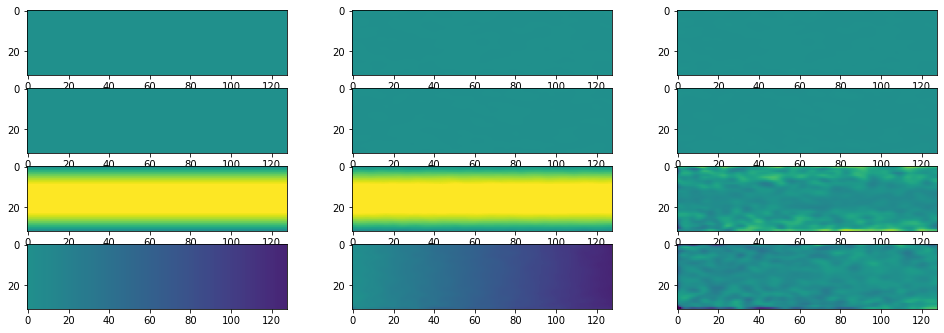

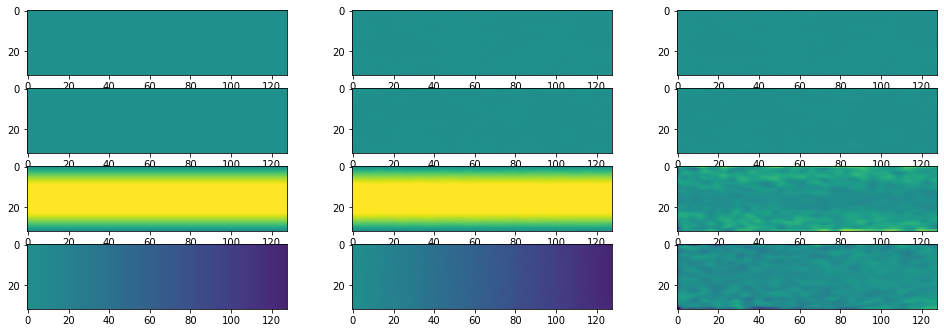

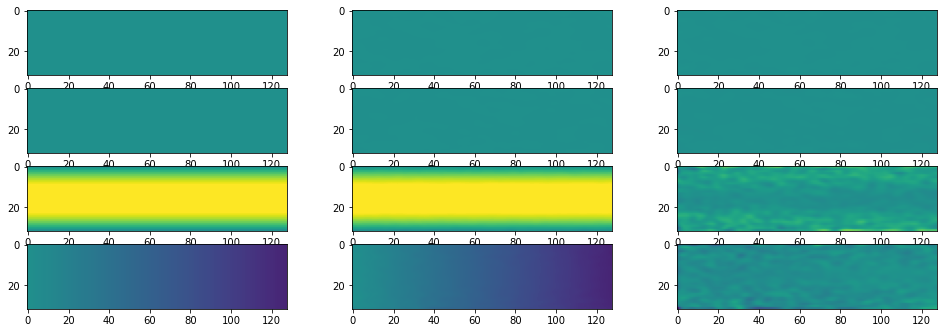

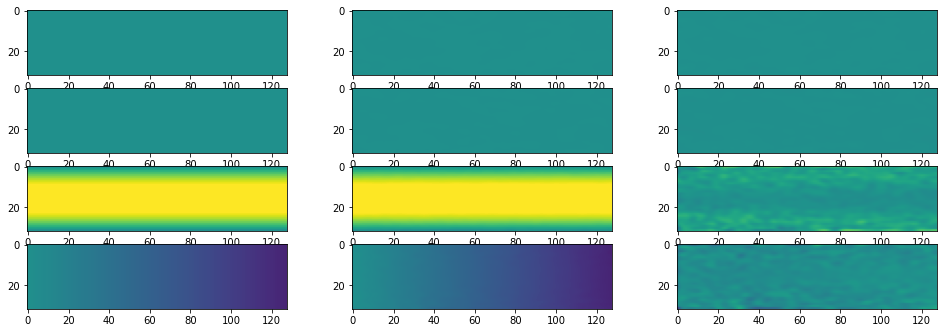

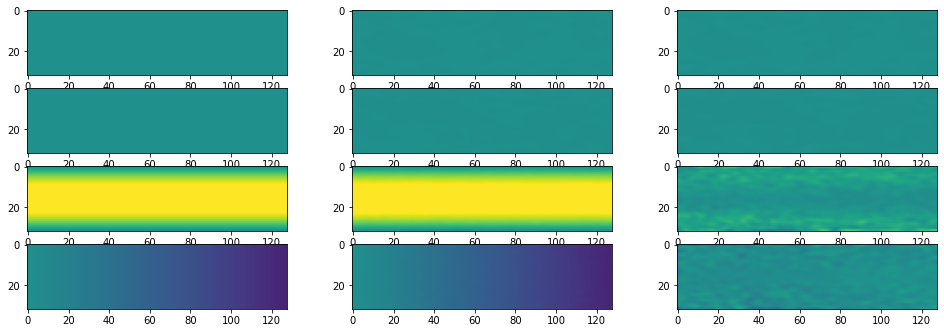

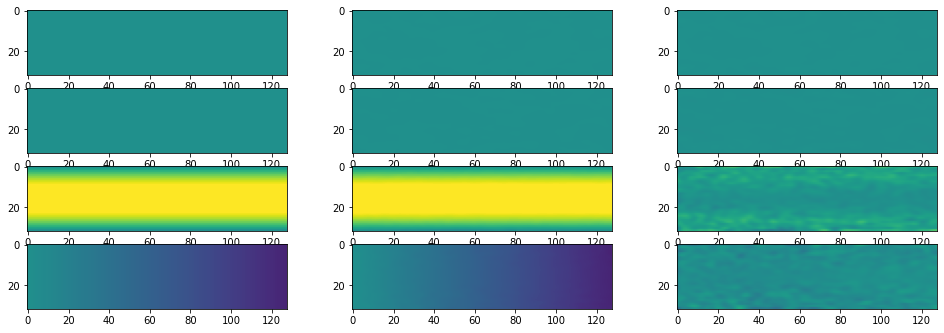

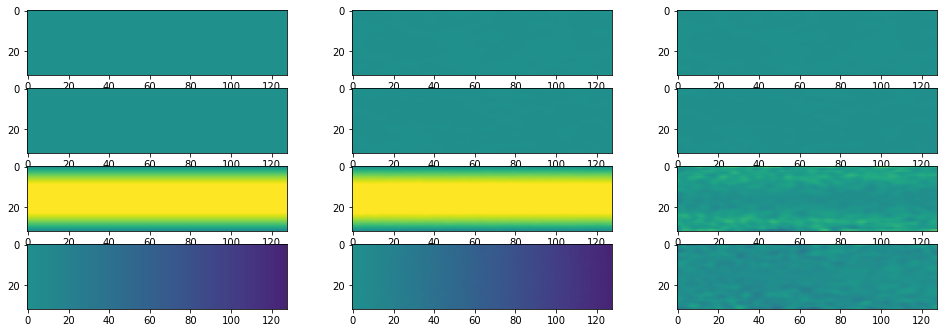

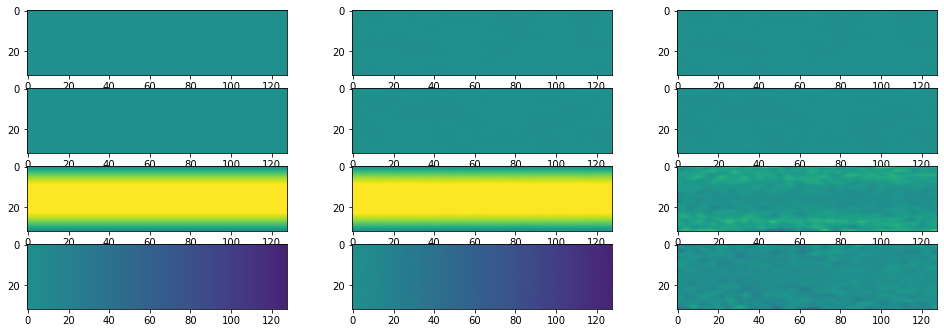

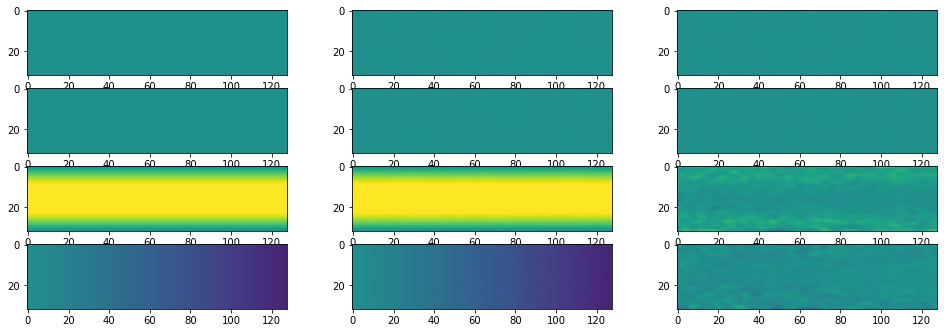

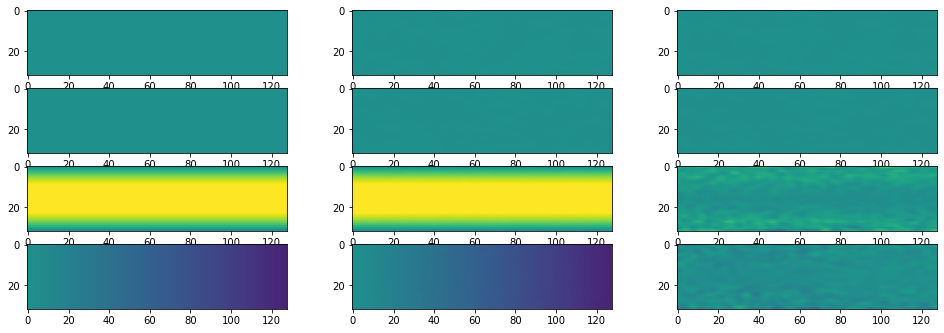

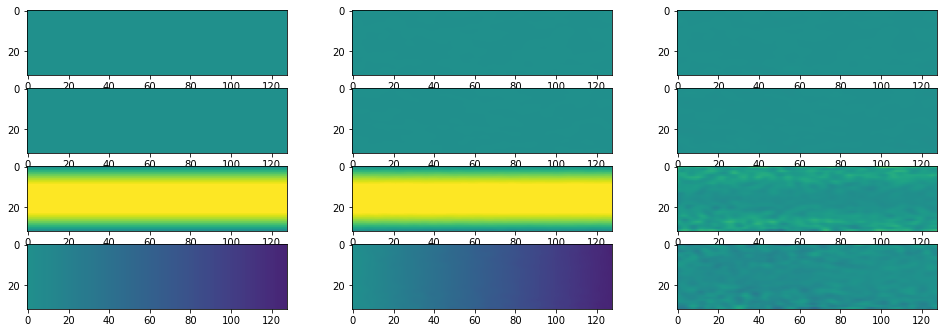

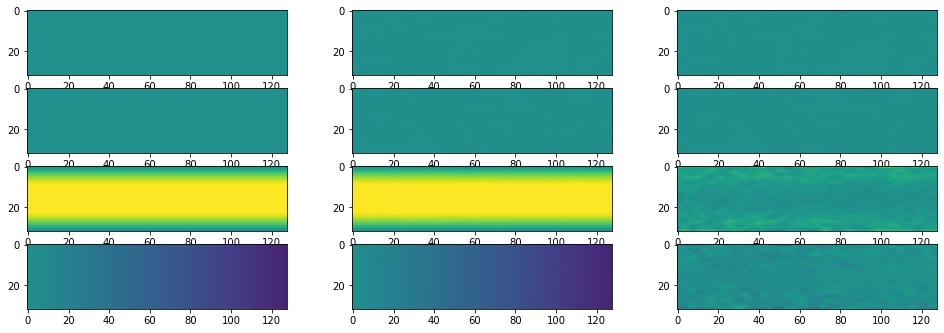

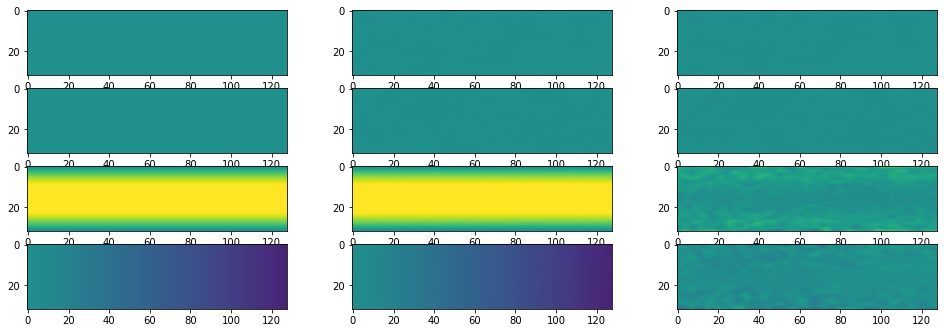

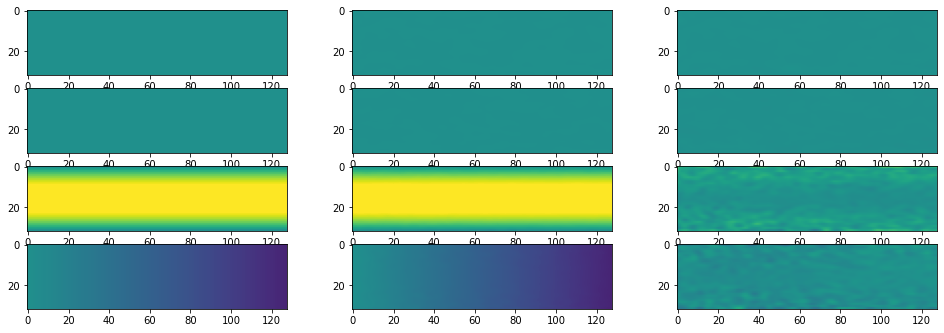

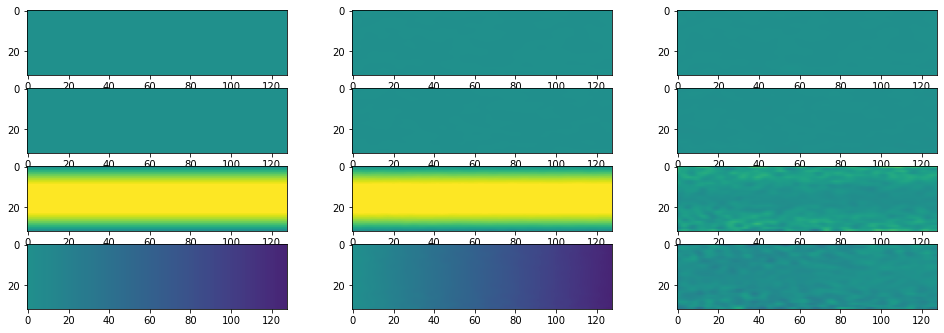

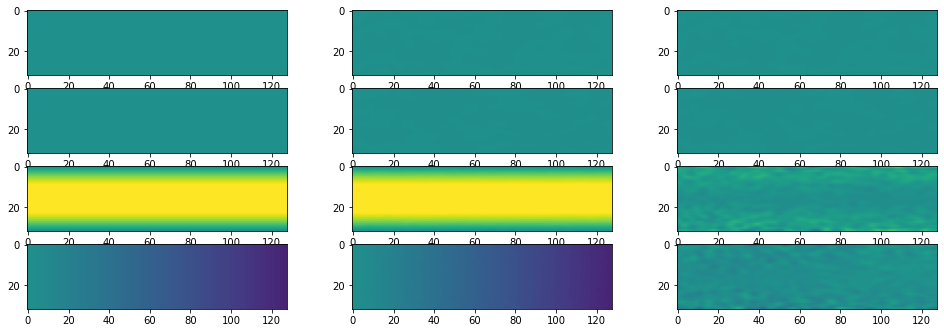

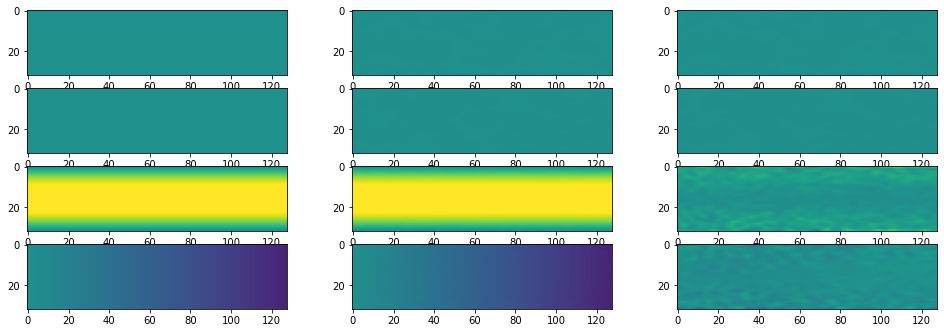

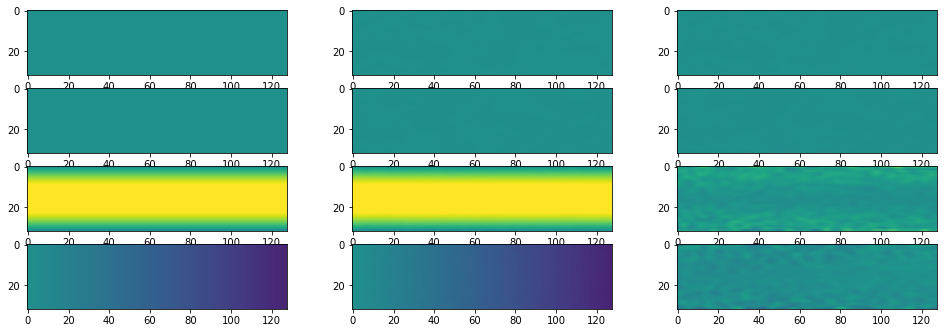

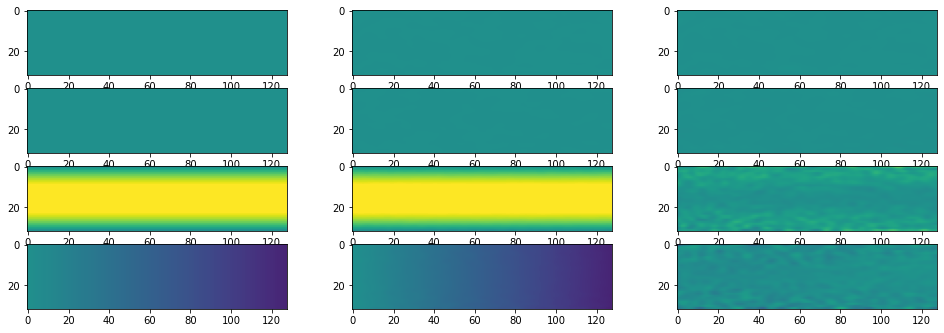

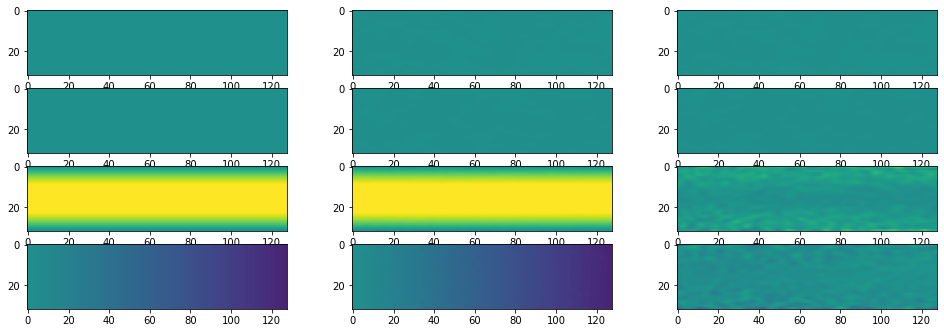

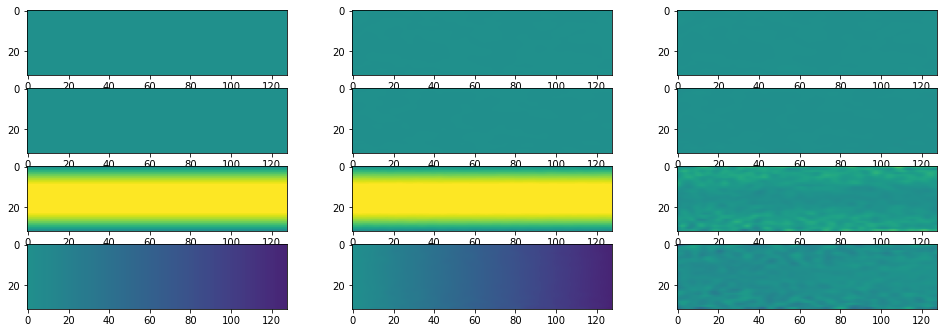

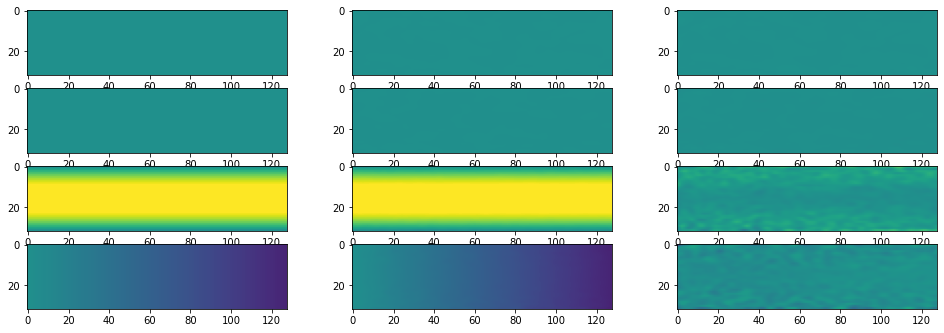

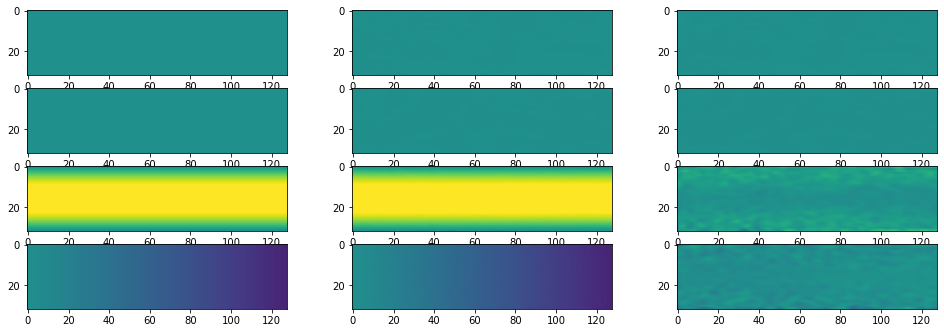

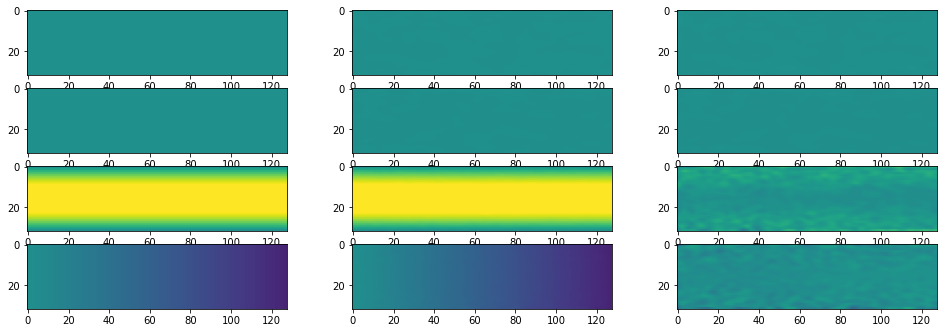

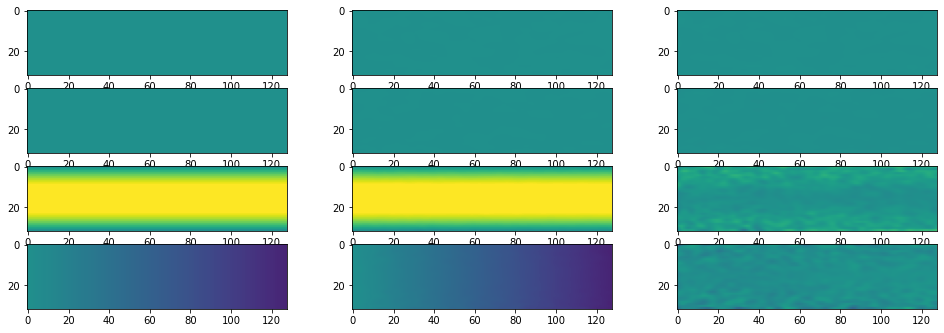

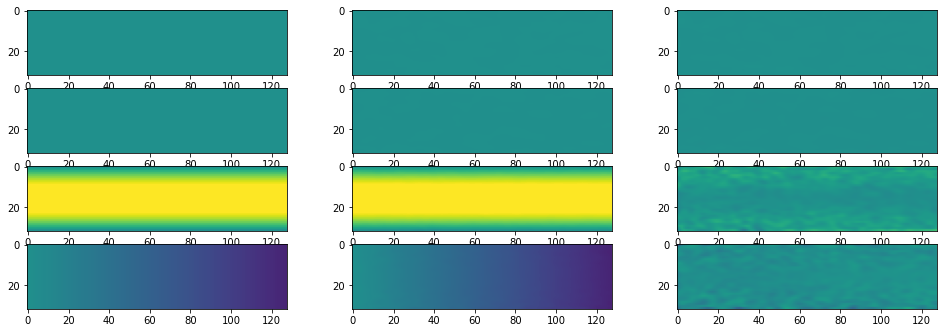

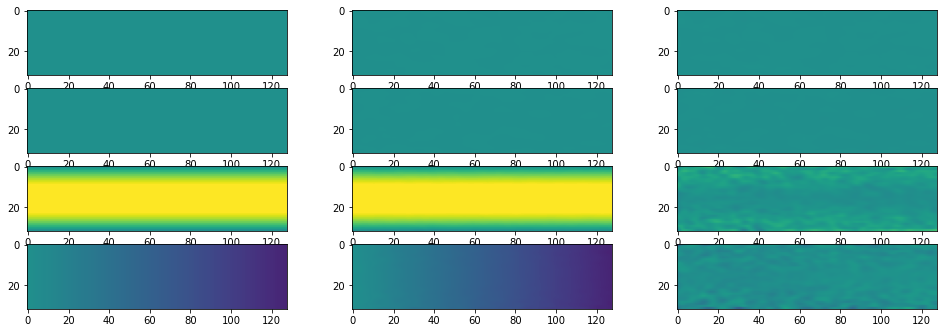

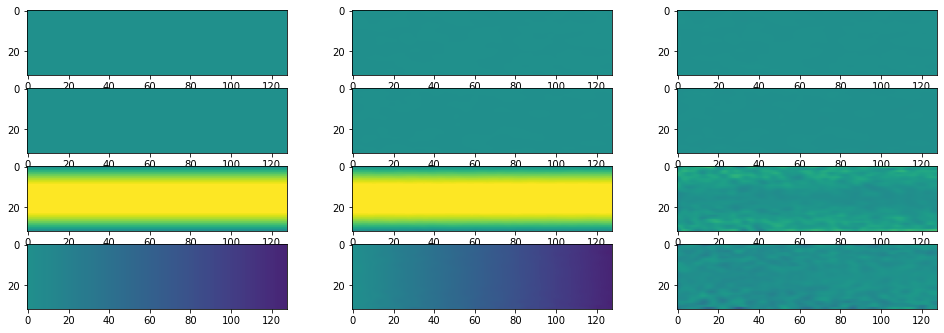

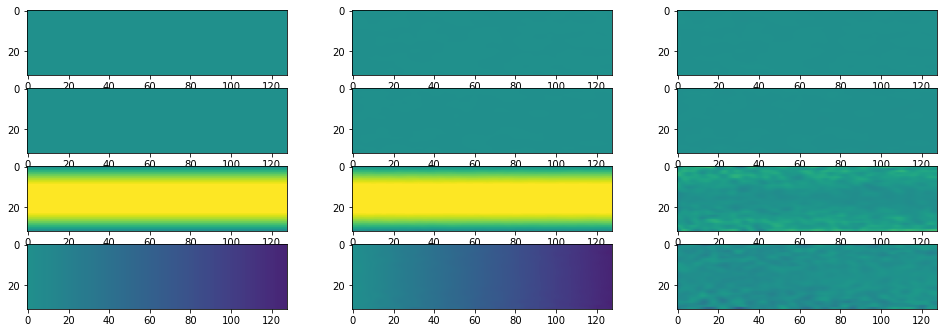

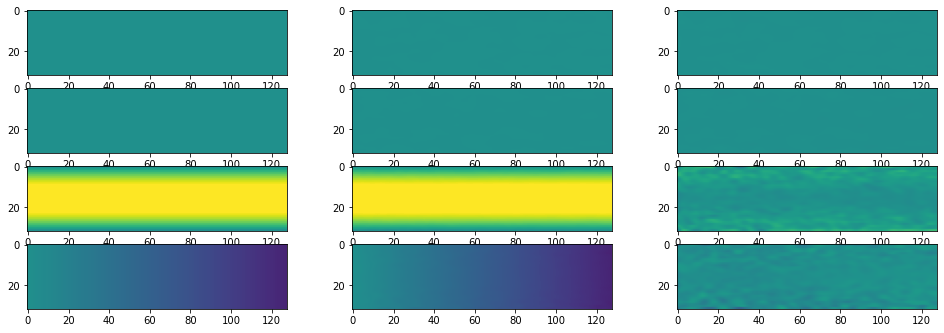

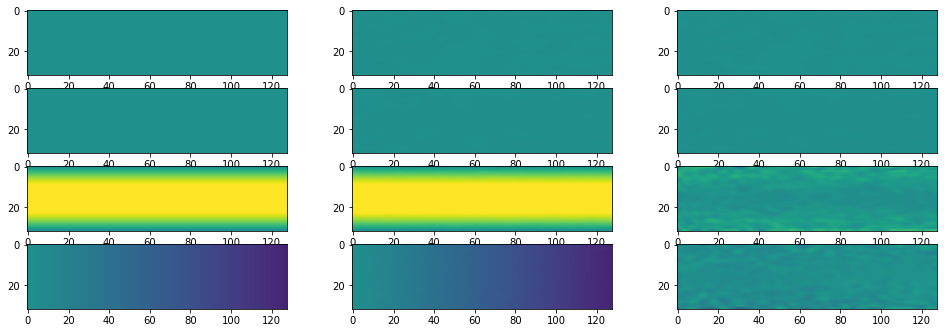

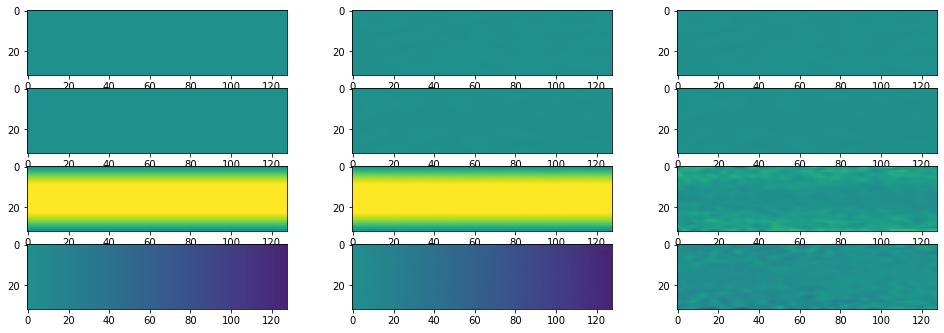

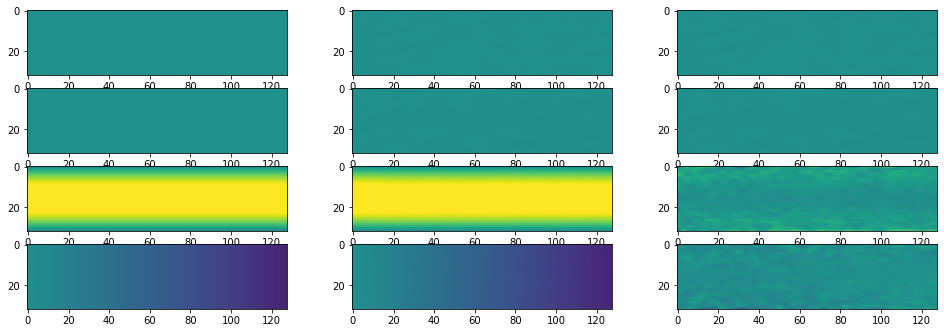

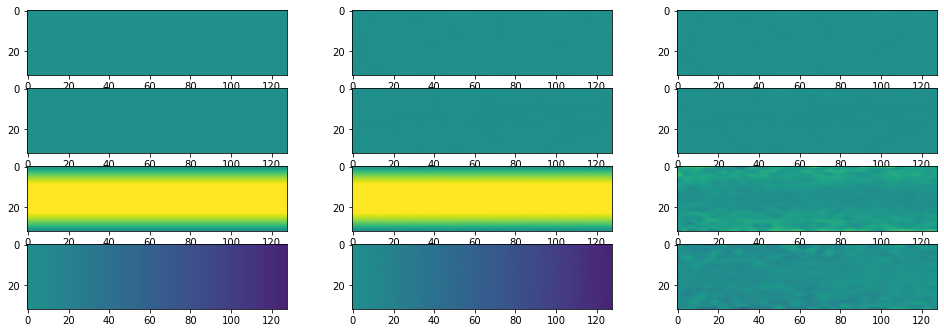

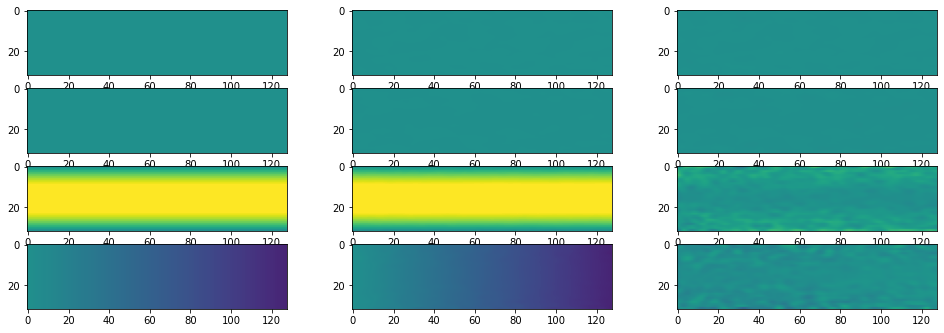

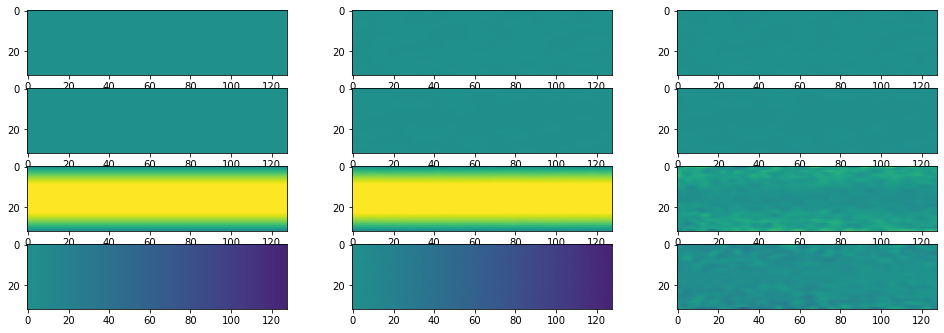

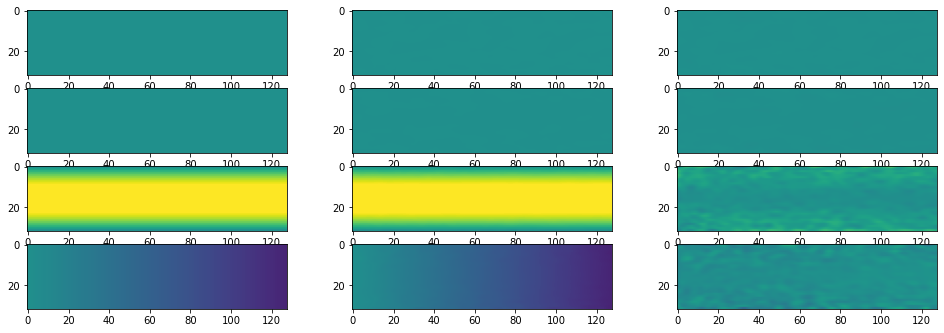

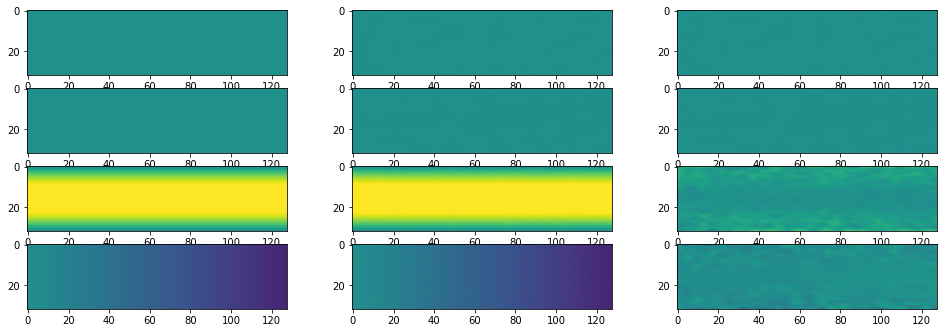

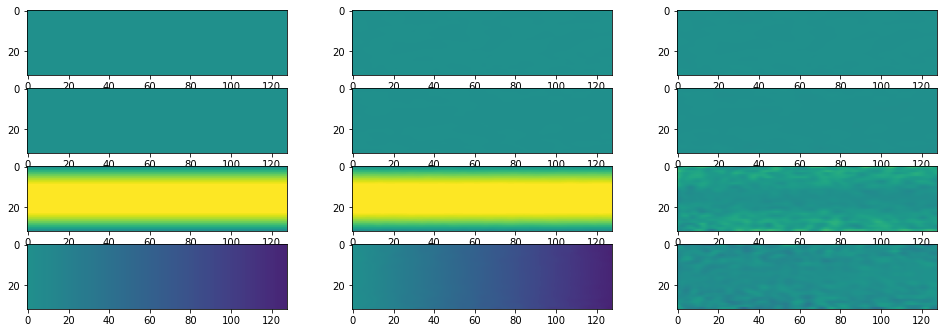

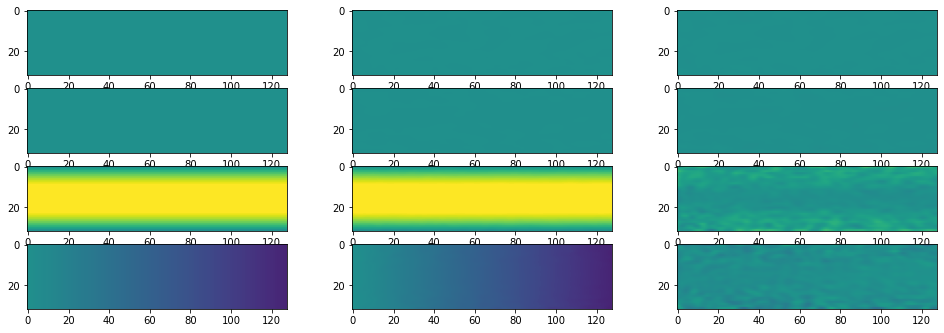

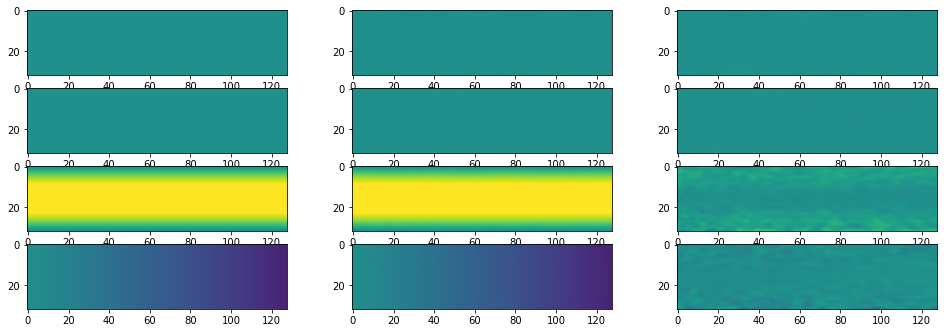

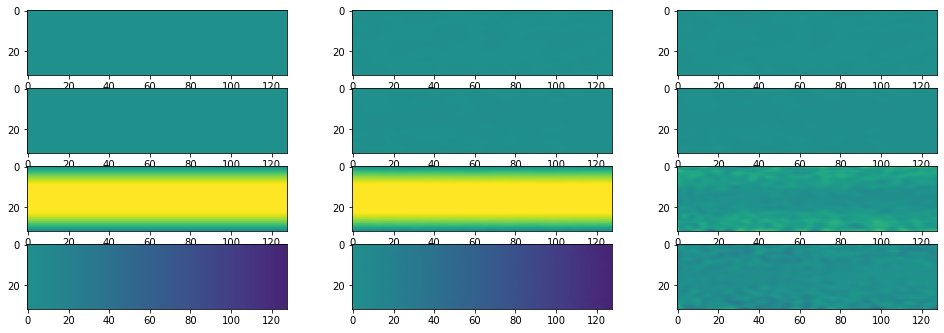

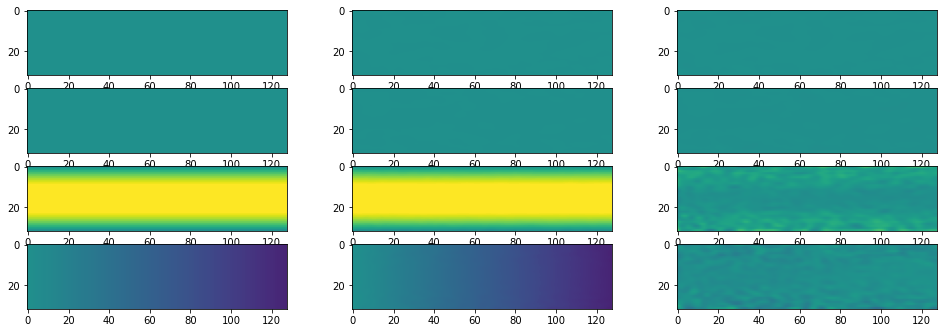

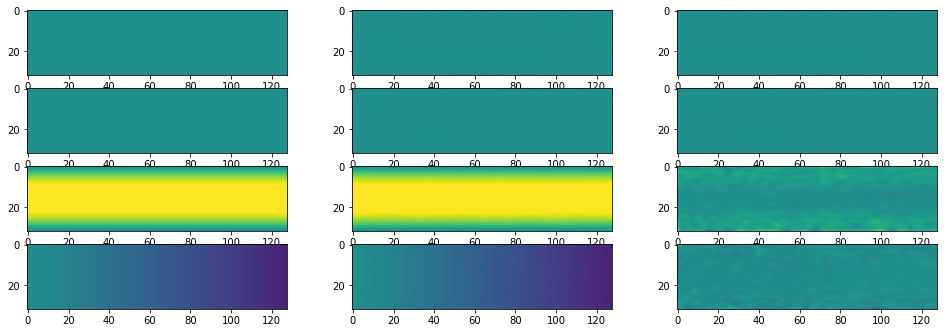

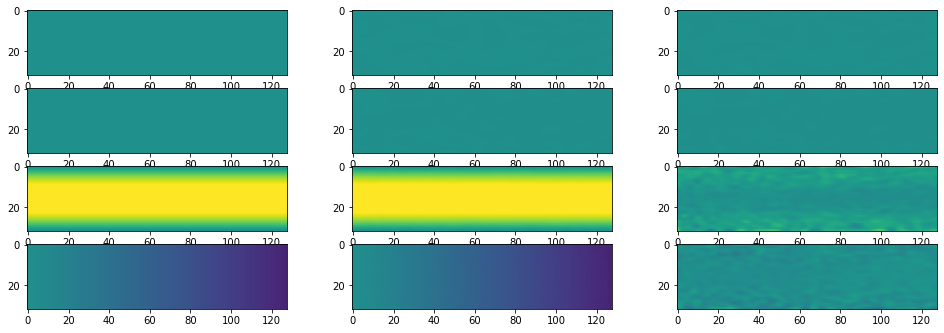

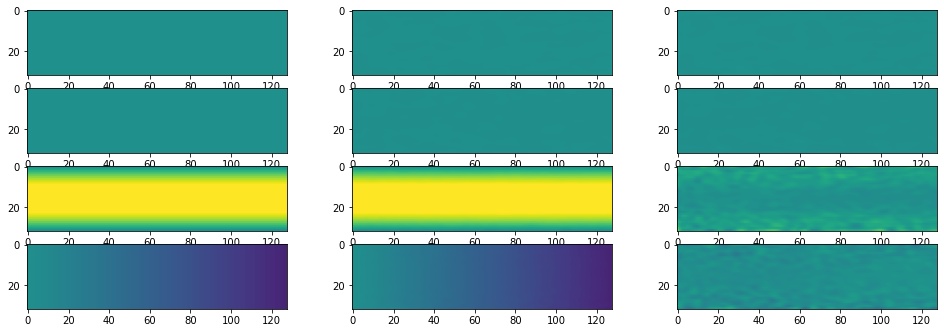

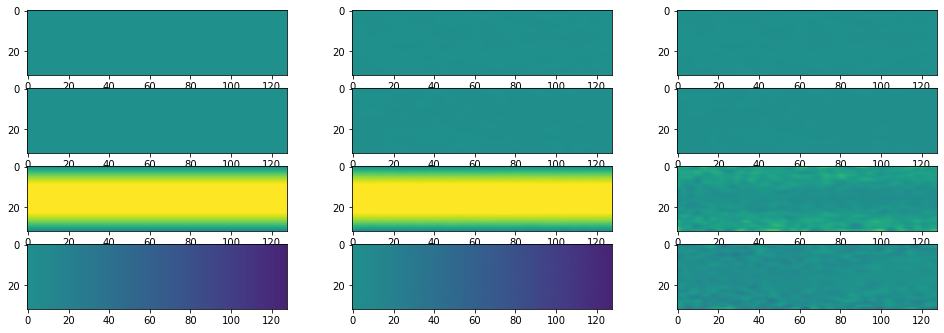

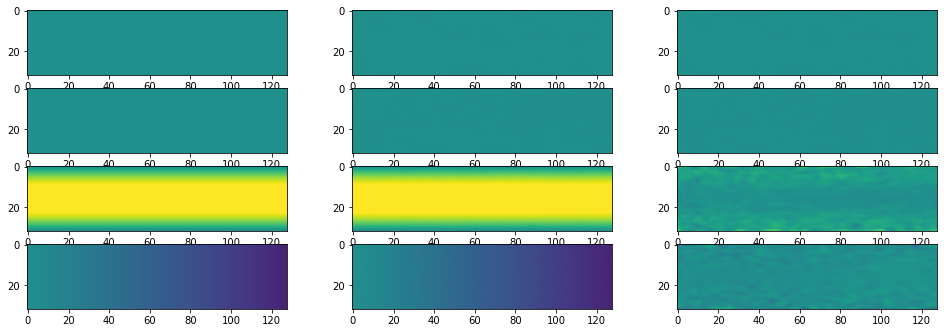

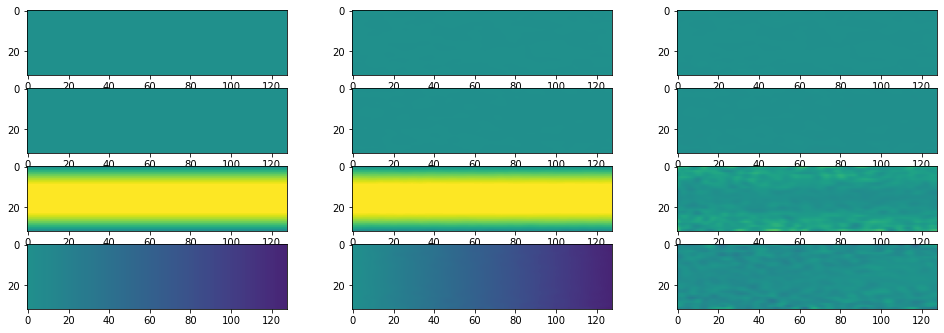

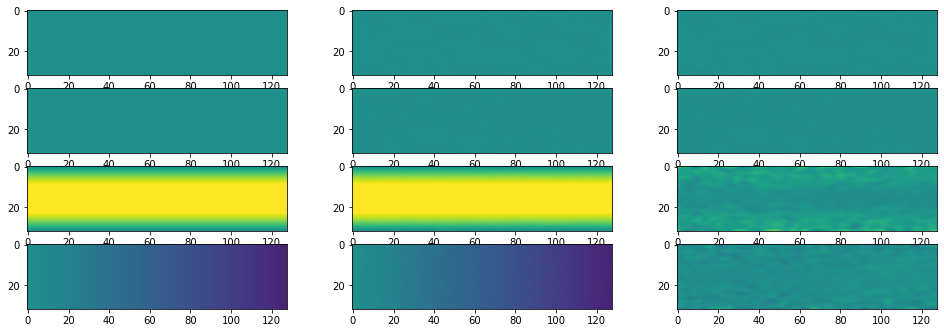

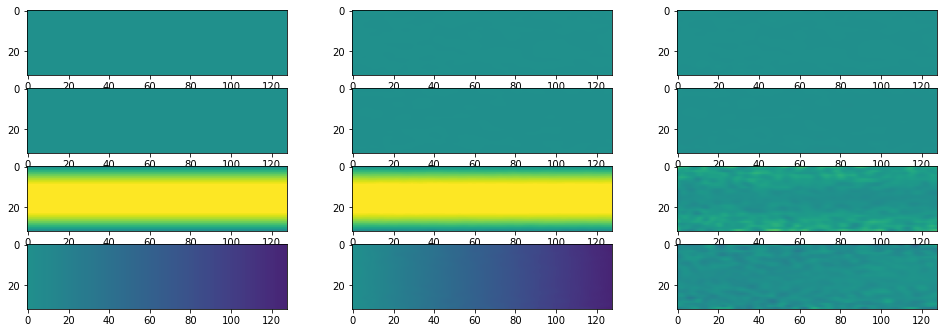

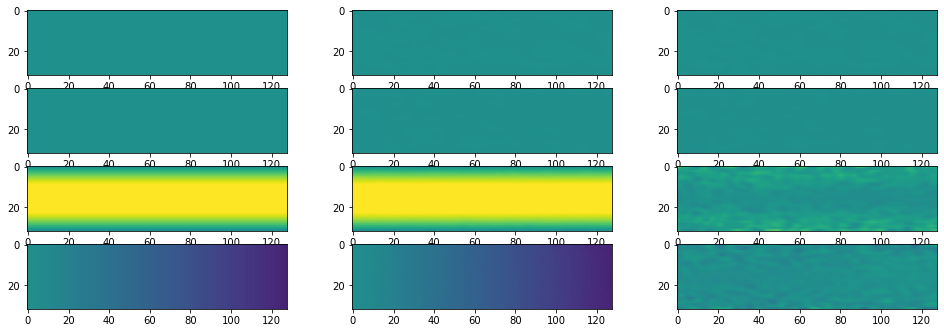

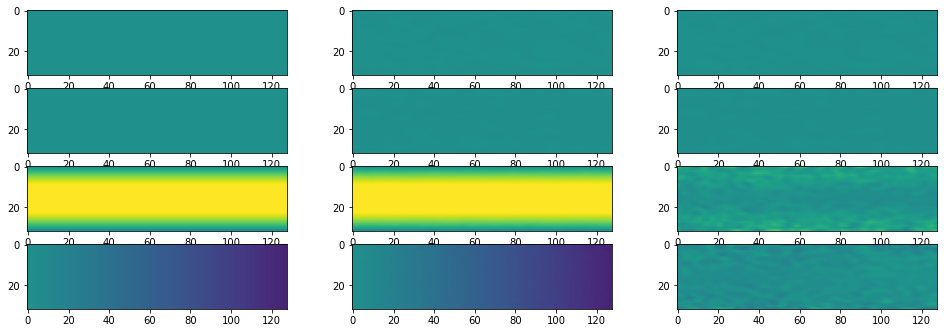

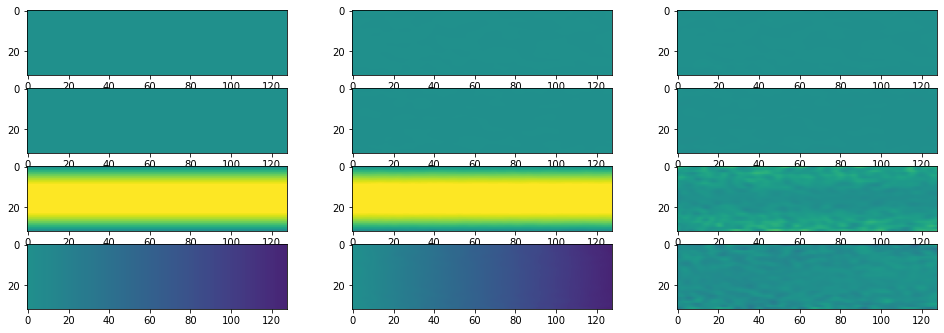

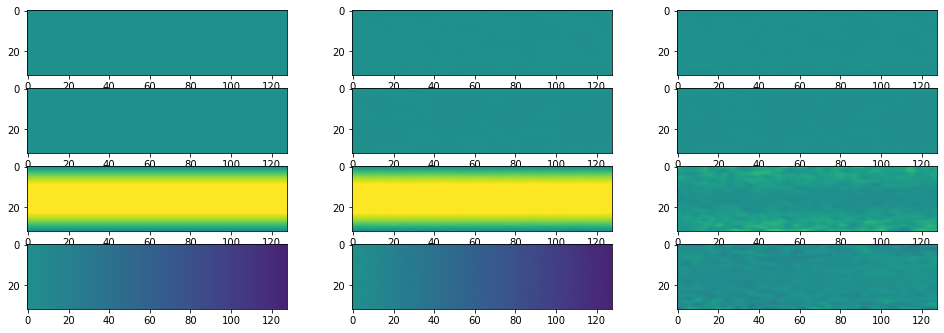

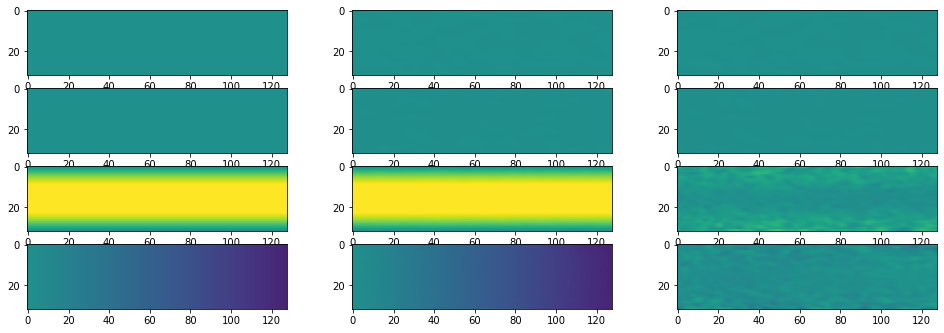

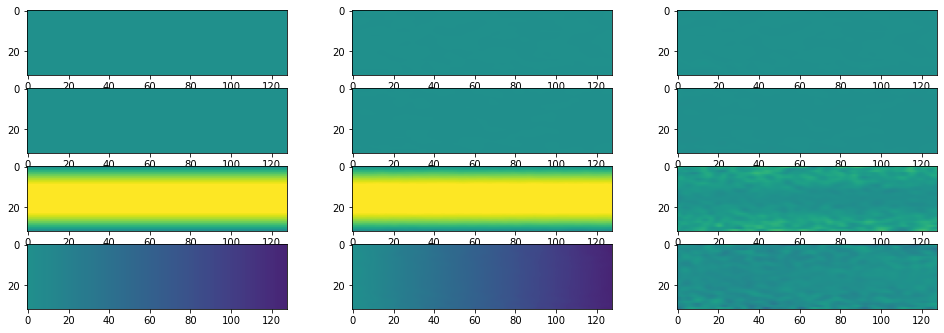

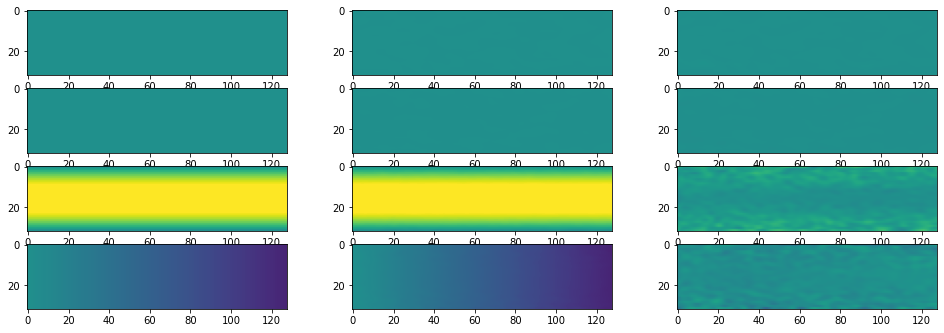

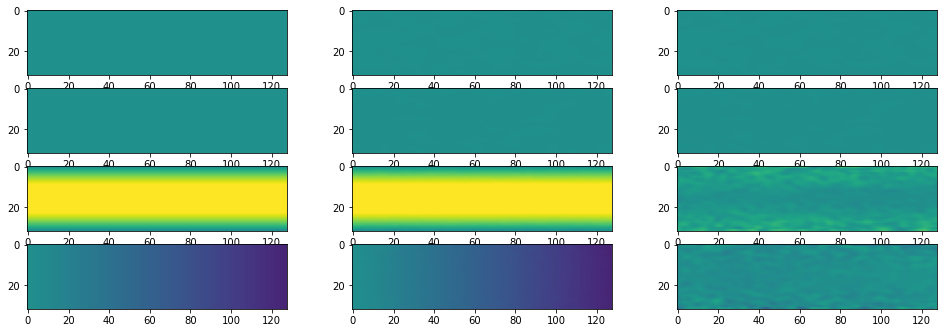

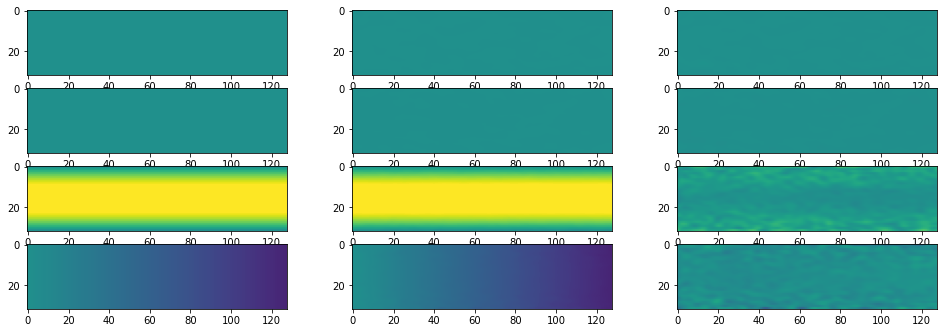

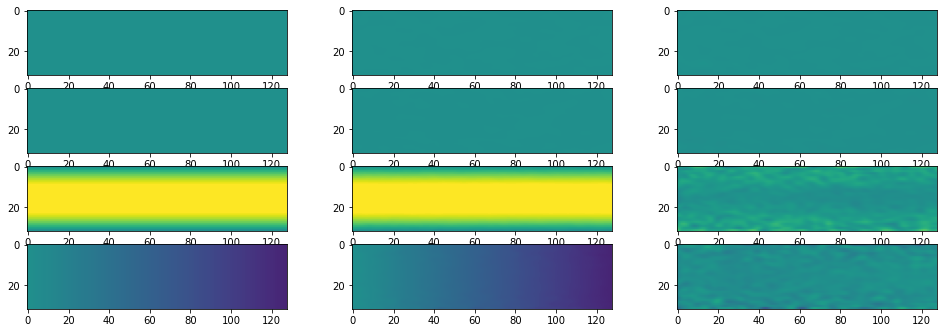

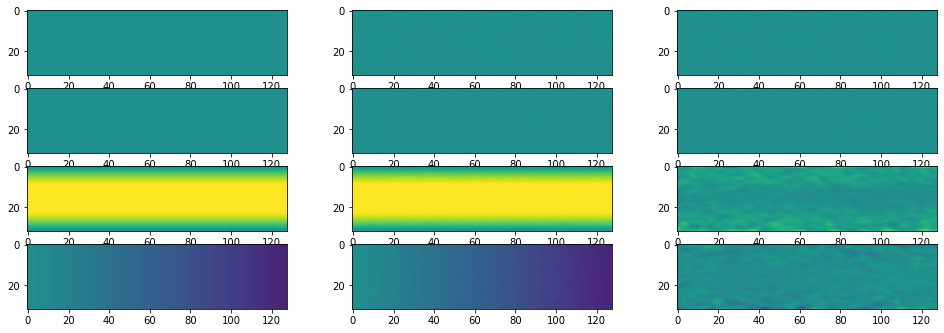

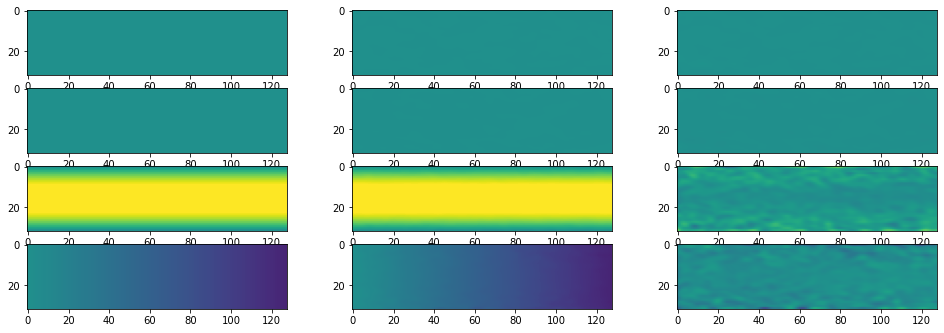

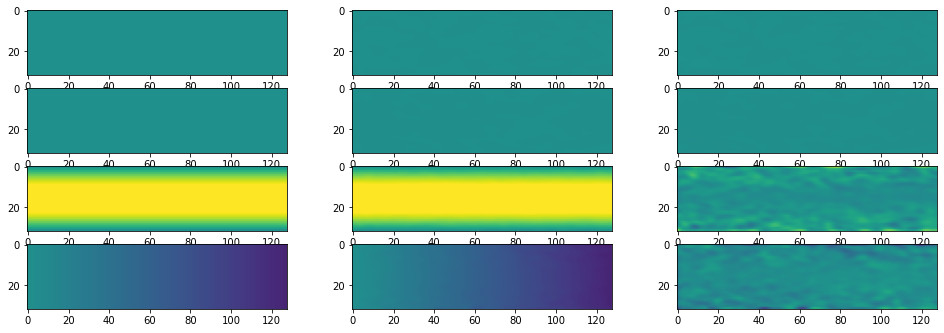

In [9]:
Nxt = 32
Nzt = 4*Nxt
Ntt = 64

xt,yt,zt,tt = np.meshgrid(np.linspace(-1,1,Nxt),np.linspace(0,0,1),np.linspace(0,4,Nzt),np.linspace(0,1,Ntt))
ut,vt,wt = staticPipe.velocity(xt,yt,zt,tt)
pt = staticPipe.pressure(xt,yt,zt,tt)
ut = np.squeeze(ut[0,:,:,:])
vt = np.squeeze(vt[0,:,:,:])
wt = np.squeeze(wt[0,:,:,:])
pt = np.squeeze(pt[0,:,:,:])


Xt = np.concatenate((xt.reshape((Nxt*Nzt*Ntt,1)),yt.reshape((Nxt*Nzt*Ntt,1)),zt.reshape((Nxt*Nzt*Ntt,1)),tt.reshape((Nxt*Nzt*Ntt,1))),axis=1)
Xt = torch.from_numpy(Xt).float().cuda()
Fpt = net(Xt)

Fpt = Fpt.cpu().detach().numpy().reshape((Nxt,1,Nzt,Ntt,4))
upt = np.squeeze(Fpt[:,0,:,:,0])
vpt = np.squeeze(Fpt[:,0,:,:,1])
wpt = np.squeeze(Fpt[:,0,:,:,2])
ppt = np.squeeze(Fpt[:,0,:,:,3])
for tn in np.arange(Ntt):
    fig, axes = plt.subplots(4,3, figsize=(16.5,5.5))
    axes[0,0].imshow(ut[:,:,tn],vmin=-1,vmax=1)
    axes[0,1].imshow(upt[:,:,tn],vmin=-1,vmax=1)
    axes[0,2].imshow(upt[:,:,tn]-ut[:,:,tn],vmin=-0.1,vmax=0.1)
    
    axes[1,0].imshow(vt[:,:,tn],vmin=-1,vmax=1)
    axes[1,1].imshow(vpt[:,:,tn],vmin=-1,vmax=1)
    axes[1,2].imshow(vpt[:,:,tn]-vt[:,:,tn],vmin=-0.1,vmax=0.1)
    
    axes[2,0].imshow(wt[:,:,tn],vmin=-1,vmax=1)
    axes[2,1].imshow(wpt[:,:,tn],vmin=-1,vmax=1)
    axes[2,2].imshow(wpt[:,:,tn]-wt[:,:,tn],vmin=-0.1,vmax=0.1)
    
    axes[3,0].imshow(pt[:,:,tn],vmin=-1,vmax=1)
    axes[3,1].imshow(ppt[:,:,tn],vmin=-1,vmax=1)
    axes[3,2].imshow(ppt[:,:,tn]-pt[:,:,tn],vmin=-0.1,vmax=0.1)
    
    
    plt.show()

In [10]:
# Solve
for step in range(n_steps):    

    overstep += 1
        
    # Inlet
    Xinlt = sampler.inlet(Np=2**8)
    Linlt = ((net(Xinlt)-pipe.fields(Xinlt))**2).mean()

    # Outlet
    Xoutl = sampler.outlet(Np=2**8)
    Loutl = ((net(Xoutl)-pipe.fields(Xoutl))**2).mean()

    # Wall
    Xwall = sampler.wall(Np=2**10)
    Nwall = sampler.wallNormal(Xwall)
#     Lwall = (velocity(Xwall,net)**2).mean()
    Lwall = (velocity(Xwall,net)**2).mean() + (pressureGradient(Xwall,net,vec=Nwall)**2).mean()
    
    # Initial
    Xinit = sampler.initial(2**12)
    Linit = ((net(Xinit)-pipe.fields(Xinit))**2).mean()

#     # Momentum
#     Xintr = sampler.interior(2**12)
#     mmx,mmy,mmz = momentum(Xintr,net,Wo)
#     Lmmnt = (mmx**2+mmy**2+mmz**2).mean()

#     # Continuity
#     Lcont = (continuity(Xintr,net)**2).mean()

    # Solve
    loss = Linlt + Loutl + Lwall + Linit


    writer.add_scalar('Inlet Loss',
                        Linlt.item(),
                        overstep)
    writer.add_scalar('Wall Loss',
                        Lwall.item(),
                        overstep)
    writer.add_scalar('Outler Loss',
                        Loutl.item(),
                        overstep)
    writer.add_scalar('Initial Condition Loss',
                        Linit.item(),
                        overstep)
#     writer.add_scalar('Momentum Loss',
#                         Lmmnt.item(),
#                         overstep)
#     writer.add_scalar('Continuity Loss',
#                         Lcont.item(),
#                         overstep)

    optim.zero_grad()
    loss.backward()
    optim.step()
        
    
    print("Solve Step: " + str(step))

Solve Step: 0
Solve Step: 1
Solve Step: 2
Solve Step: 3
Solve Step: 4
Solve Step: 5
Solve Step: 6
Solve Step: 7
Solve Step: 8
Solve Step: 9
Solve Step: 10
Solve Step: 11
Solve Step: 12
Solve Step: 13
Solve Step: 14
Solve Step: 15
Solve Step: 16
Solve Step: 17
Solve Step: 18
Solve Step: 19
Solve Step: 20
Solve Step: 21
Solve Step: 22
Solve Step: 23
Solve Step: 24
Solve Step: 25
Solve Step: 26
Solve Step: 27
Solve Step: 28
Solve Step: 29
Solve Step: 30
Solve Step: 31
Solve Step: 32
Solve Step: 33
Solve Step: 34
Solve Step: 35
Solve Step: 36
Solve Step: 37
Solve Step: 38
Solve Step: 39
Solve Step: 40
Solve Step: 41
Solve Step: 42
Solve Step: 43
Solve Step: 44
Solve Step: 45
Solve Step: 46
Solve Step: 47
Solve Step: 48
Solve Step: 49
Solve Step: 50
Solve Step: 51
Solve Step: 52
Solve Step: 53
Solve Step: 54
Solve Step: 55
Solve Step: 56
Solve Step: 57
Solve Step: 58
Solve Step: 59
Solve Step: 60
Solve Step: 61
Solve Step: 62
Solve Step: 63
Solve Step: 64
Solve Step: 65
Solve Step: 66
Solve

Solve Step: 520
Solve Step: 521
Solve Step: 522
Solve Step: 523
Solve Step: 524
Solve Step: 525
Solve Step: 526
Solve Step: 527
Solve Step: 528
Solve Step: 529
Solve Step: 530
Solve Step: 531
Solve Step: 532
Solve Step: 533
Solve Step: 534
Solve Step: 535
Solve Step: 536
Solve Step: 537
Solve Step: 538
Solve Step: 539
Solve Step: 540
Solve Step: 541
Solve Step: 542
Solve Step: 543
Solve Step: 544
Solve Step: 545
Solve Step: 546
Solve Step: 547
Solve Step: 548
Solve Step: 549
Solve Step: 550
Solve Step: 551
Solve Step: 552
Solve Step: 553
Solve Step: 554
Solve Step: 555
Solve Step: 556
Solve Step: 557
Solve Step: 558
Solve Step: 559
Solve Step: 560
Solve Step: 561
Solve Step: 562
Solve Step: 563
Solve Step: 564
Solve Step: 565
Solve Step: 566
Solve Step: 567
Solve Step: 568
Solve Step: 569
Solve Step: 570
Solve Step: 571
Solve Step: 572
Solve Step: 573
Solve Step: 574
Solve Step: 575
Solve Step: 576
Solve Step: 577
Solve Step: 578
Solve Step: 579
Solve Step: 580
Solve Step: 581
Solve St

Solve Step: 1033
Solve Step: 1034
Solve Step: 1035
Solve Step: 1036
Solve Step: 1037
Solve Step: 1038
Solve Step: 1039
Solve Step: 1040
Solve Step: 1041
Solve Step: 1042
Solve Step: 1043
Solve Step: 1044
Solve Step: 1045
Solve Step: 1046
Solve Step: 1047
Solve Step: 1048
Solve Step: 1049
Solve Step: 1050
Solve Step: 1051
Solve Step: 1052
Solve Step: 1053
Solve Step: 1054
Solve Step: 1055
Solve Step: 1056
Solve Step: 1057
Solve Step: 1058
Solve Step: 1059
Solve Step: 1060
Solve Step: 1061
Solve Step: 1062
Solve Step: 1063
Solve Step: 1064
Solve Step: 1065
Solve Step: 1066
Solve Step: 1067
Solve Step: 1068
Solve Step: 1069
Solve Step: 1070
Solve Step: 1071
Solve Step: 1072
Solve Step: 1073
Solve Step: 1074
Solve Step: 1075
Solve Step: 1076
Solve Step: 1077
Solve Step: 1078
Solve Step: 1079
Solve Step: 1080
Solve Step: 1081
Solve Step: 1082
Solve Step: 1083
Solve Step: 1084
Solve Step: 1085
Solve Step: 1086
Solve Step: 1087
Solve Step: 1088
Solve Step: 1089
Solve Step: 1090
Solve Step: 10

Solve Step: 1516
Solve Step: 1517
Solve Step: 1518
Solve Step: 1519
Solve Step: 1520
Solve Step: 1521
Solve Step: 1522
Solve Step: 1523
Solve Step: 1524
Solve Step: 1525
Solve Step: 1526
Solve Step: 1527
Solve Step: 1528
Solve Step: 1529
Solve Step: 1530
Solve Step: 1531
Solve Step: 1532
Solve Step: 1533
Solve Step: 1534
Solve Step: 1535
Solve Step: 1536
Solve Step: 1537
Solve Step: 1538
Solve Step: 1539
Solve Step: 1540
Solve Step: 1541
Solve Step: 1542
Solve Step: 1543
Solve Step: 1544
Solve Step: 1545
Solve Step: 1546
Solve Step: 1547
Solve Step: 1548
Solve Step: 1549
Solve Step: 1550
Solve Step: 1551
Solve Step: 1552
Solve Step: 1553
Solve Step: 1554
Solve Step: 1555
Solve Step: 1556
Solve Step: 1557
Solve Step: 1558
Solve Step: 1559
Solve Step: 1560
Solve Step: 1561
Solve Step: 1562
Solve Step: 1563
Solve Step: 1564
Solve Step: 1565
Solve Step: 1566
Solve Step: 1567
Solve Step: 1568
Solve Step: 1569
Solve Step: 1570
Solve Step: 1571
Solve Step: 1572
Solve Step: 1573
Solve Step: 15

Solve Step: 1999
Solve Step: 2000
Solve Step: 2001
Solve Step: 2002
Solve Step: 2003
Solve Step: 2004
Solve Step: 2005
Solve Step: 2006
Solve Step: 2007
Solve Step: 2008
Solve Step: 2009
Solve Step: 2010
Solve Step: 2011
Solve Step: 2012
Solve Step: 2013
Solve Step: 2014
Solve Step: 2015
Solve Step: 2016
Solve Step: 2017
Solve Step: 2018
Solve Step: 2019
Solve Step: 2020
Solve Step: 2021
Solve Step: 2022
Solve Step: 2023
Solve Step: 2024
Solve Step: 2025
Solve Step: 2026
Solve Step: 2027
Solve Step: 2028
Solve Step: 2029
Solve Step: 2030
Solve Step: 2031
Solve Step: 2032
Solve Step: 2033
Solve Step: 2034
Solve Step: 2035
Solve Step: 2036
Solve Step: 2037
Solve Step: 2038
Solve Step: 2039
Solve Step: 2040
Solve Step: 2041
Solve Step: 2042
Solve Step: 2043
Solve Step: 2044
Solve Step: 2045
Solve Step: 2046
Solve Step: 2047
Solve Step: 2048
Solve Step: 2049
Solve Step: 2050
Solve Step: 2051
Solve Step: 2052
Solve Step: 2053
Solve Step: 2054
Solve Step: 2055
Solve Step: 2056
Solve Step: 20

Solve Step: 2480
Solve Step: 2481
Solve Step: 2482
Solve Step: 2483
Solve Step: 2484
Solve Step: 2485
Solve Step: 2486
Solve Step: 2487
Solve Step: 2488
Solve Step: 2489
Solve Step: 2490
Solve Step: 2491
Solve Step: 2492
Solve Step: 2493
Solve Step: 2494
Solve Step: 2495
Solve Step: 2496
Solve Step: 2497
Solve Step: 2498
Solve Step: 2499
Solve Step: 2500
Solve Step: 2501
Solve Step: 2502
Solve Step: 2503
Solve Step: 2504
Solve Step: 2505
Solve Step: 2506
Solve Step: 2507
Solve Step: 2508
Solve Step: 2509
Solve Step: 2510
Solve Step: 2511
Solve Step: 2512
Solve Step: 2513
Solve Step: 2514
Solve Step: 2515
Solve Step: 2516
Solve Step: 2517
Solve Step: 2518
Solve Step: 2519
Solve Step: 2520
Solve Step: 2521
Solve Step: 2522
Solve Step: 2523
Solve Step: 2524
Solve Step: 2525
Solve Step: 2526
Solve Step: 2527
Solve Step: 2528
Solve Step: 2529
Solve Step: 2530
Solve Step: 2531
Solve Step: 2532
Solve Step: 2533
Solve Step: 2534
Solve Step: 2535
Solve Step: 2536
Solve Step: 2537
Solve Step: 25

Solve Step: 2963
Solve Step: 2964
Solve Step: 2965
Solve Step: 2966
Solve Step: 2967
Solve Step: 2968
Solve Step: 2969
Solve Step: 2970
Solve Step: 2971
Solve Step: 2972
Solve Step: 2973
Solve Step: 2974
Solve Step: 2975
Solve Step: 2976
Solve Step: 2977
Solve Step: 2978
Solve Step: 2979
Solve Step: 2980
Solve Step: 2981
Solve Step: 2982
Solve Step: 2983
Solve Step: 2984
Solve Step: 2985
Solve Step: 2986
Solve Step: 2987
Solve Step: 2988
Solve Step: 2989
Solve Step: 2990
Solve Step: 2991
Solve Step: 2992
Solve Step: 2993
Solve Step: 2994
Solve Step: 2995
Solve Step: 2996
Solve Step: 2997
Solve Step: 2998
Solve Step: 2999
Solve Step: 3000
Solve Step: 3001
Solve Step: 3002
Solve Step: 3003
Solve Step: 3004
Solve Step: 3005
Solve Step: 3006
Solve Step: 3007
Solve Step: 3008
Solve Step: 3009
Solve Step: 3010
Solve Step: 3011
Solve Step: 3012
Solve Step: 3013
Solve Step: 3014
Solve Step: 3015
Solve Step: 3016
Solve Step: 3017
Solve Step: 3018
Solve Step: 3019
Solve Step: 3020
Solve Step: 30

Solve Step: 3446
Solve Step: 3447
Solve Step: 3448
Solve Step: 3449
Solve Step: 3450
Solve Step: 3451
Solve Step: 3452
Solve Step: 3453
Solve Step: 3454
Solve Step: 3455
Solve Step: 3456
Solve Step: 3457
Solve Step: 3458
Solve Step: 3459
Solve Step: 3460
Solve Step: 3461
Solve Step: 3462
Solve Step: 3463
Solve Step: 3464
Solve Step: 3465
Solve Step: 3466
Solve Step: 3467
Solve Step: 3468
Solve Step: 3469
Solve Step: 3470
Solve Step: 3471
Solve Step: 3472
Solve Step: 3473
Solve Step: 3474
Solve Step: 3475
Solve Step: 3476
Solve Step: 3477
Solve Step: 3478
Solve Step: 3479
Solve Step: 3480
Solve Step: 3481
Solve Step: 3482
Solve Step: 3483
Solve Step: 3484
Solve Step: 3485
Solve Step: 3486
Solve Step: 3487
Solve Step: 3488
Solve Step: 3489
Solve Step: 3490
Solve Step: 3491
Solve Step: 3492
Solve Step: 3493
Solve Step: 3494
Solve Step: 3495
Solve Step: 3496
Solve Step: 3497
Solve Step: 3498
Solve Step: 3499
Solve Step: 3500
Solve Step: 3501
Solve Step: 3502
Solve Step: 3503
Solve Step: 35

KeyboardInterrupt: 

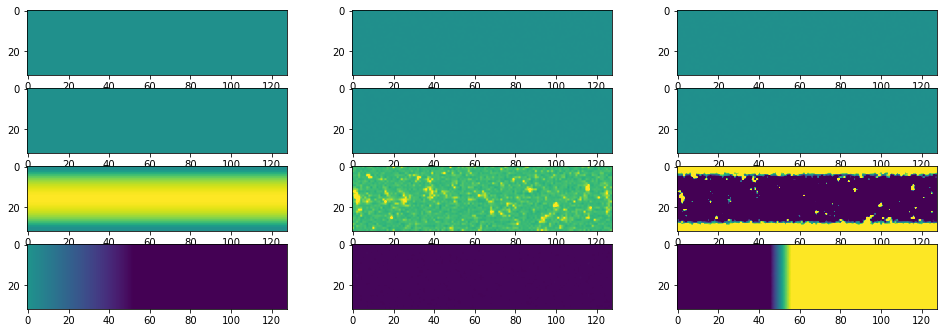

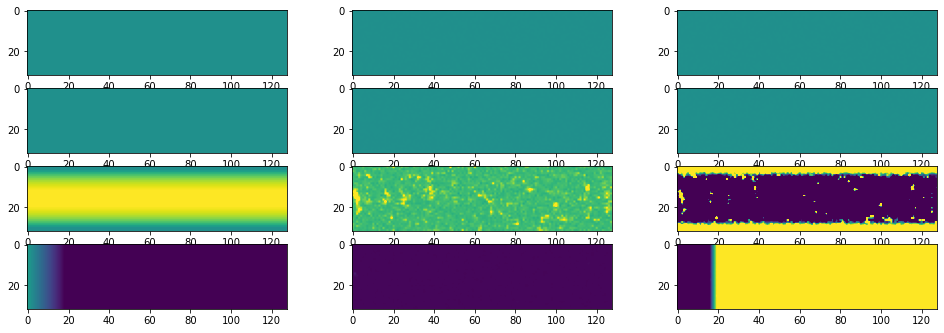

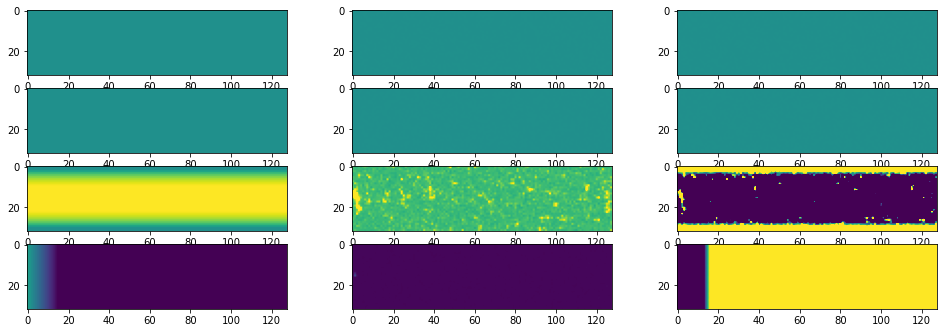

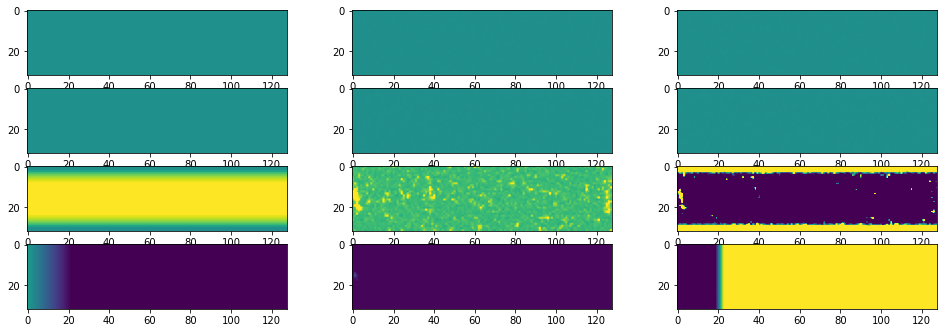

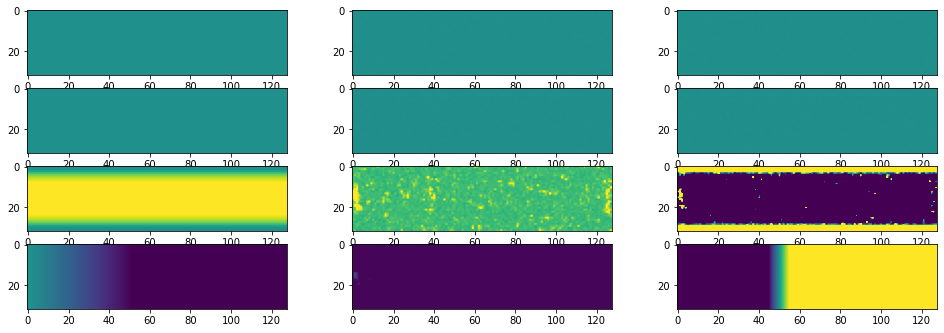

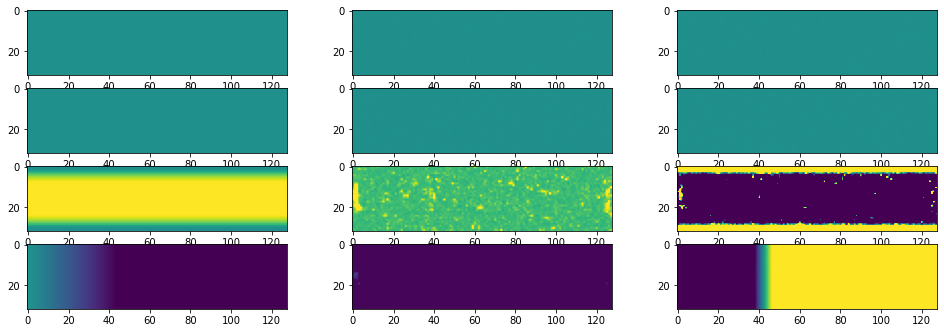

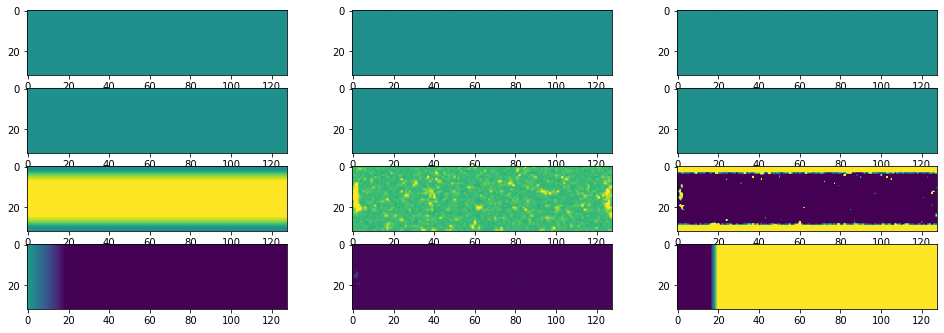

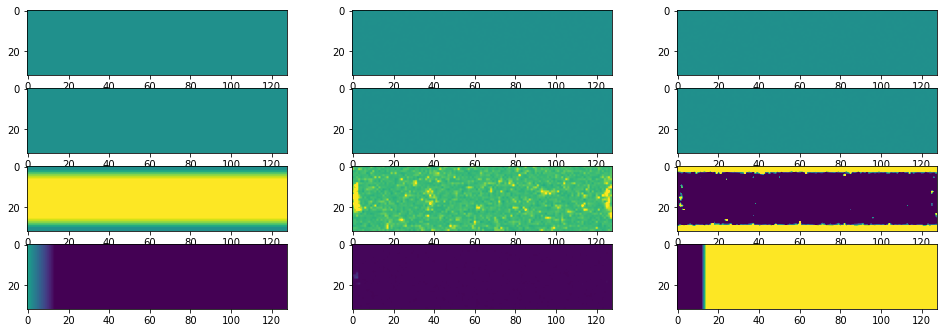

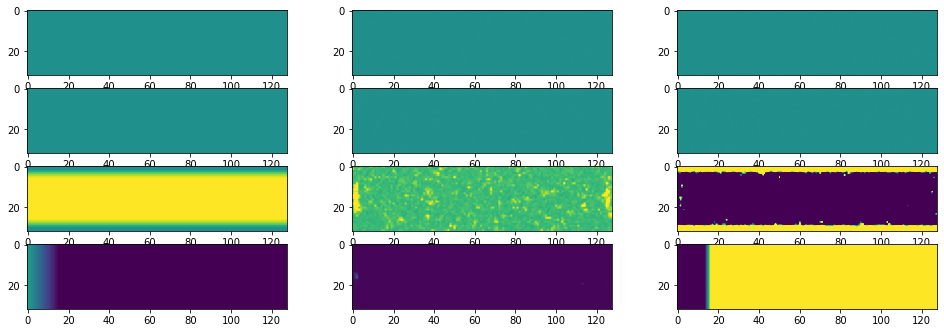

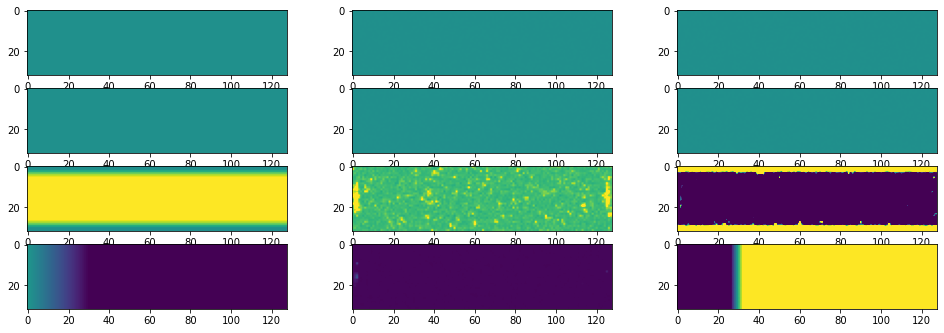

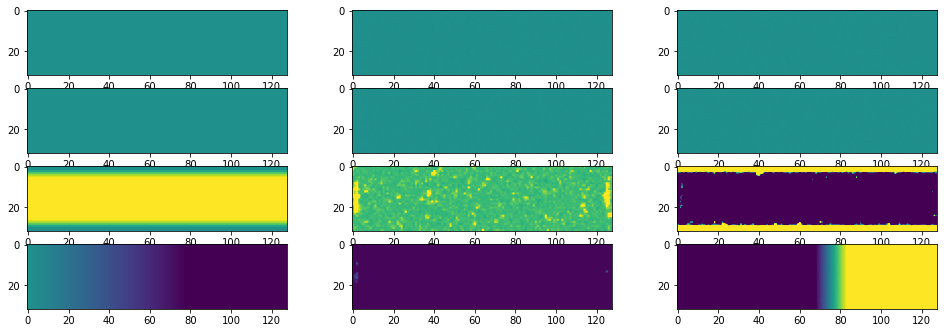

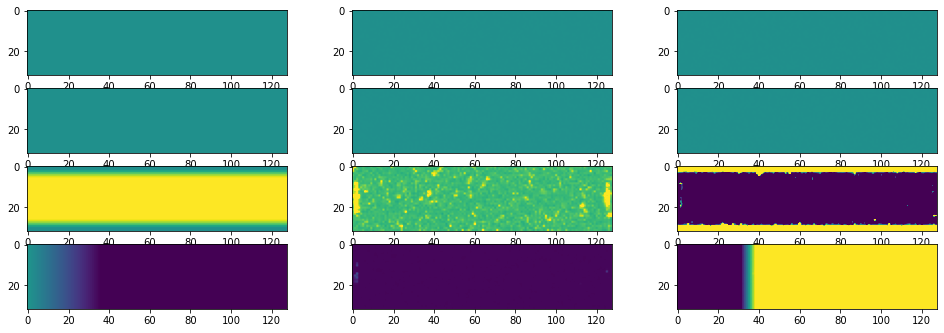

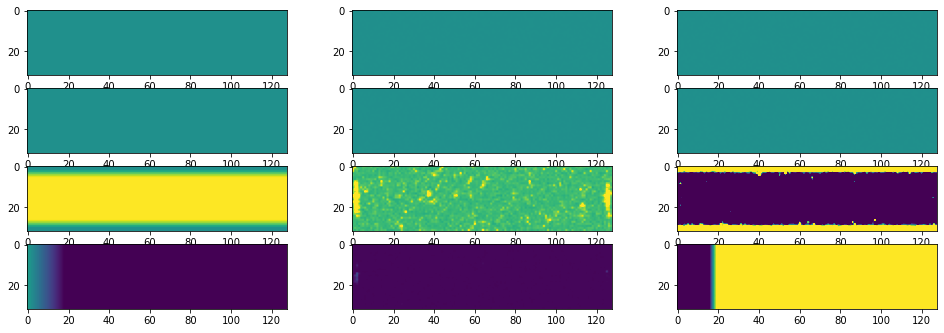

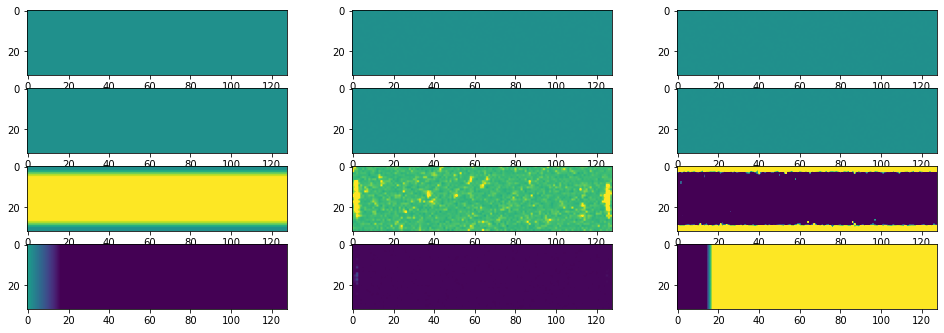

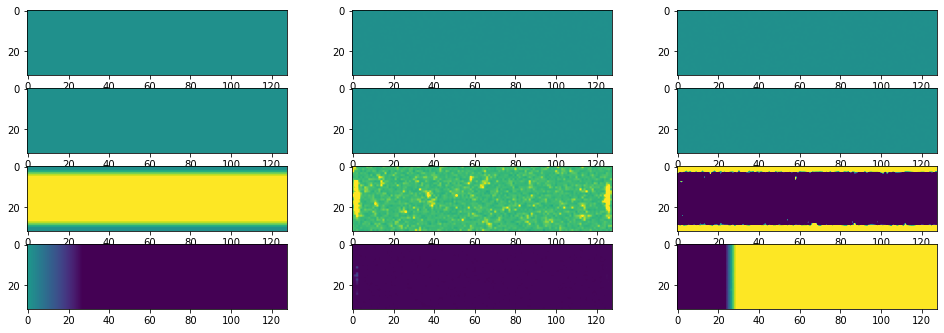

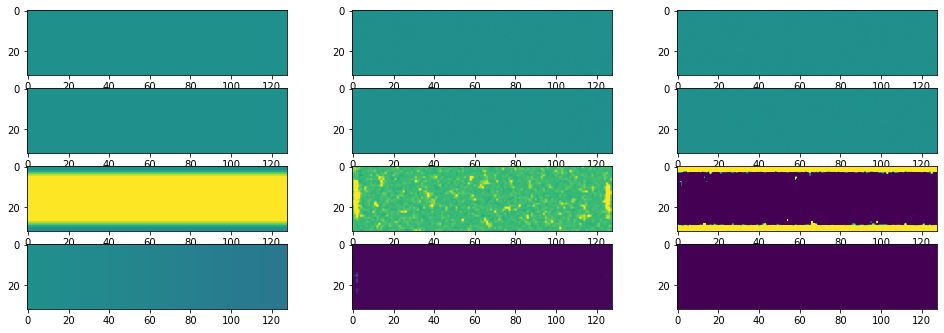

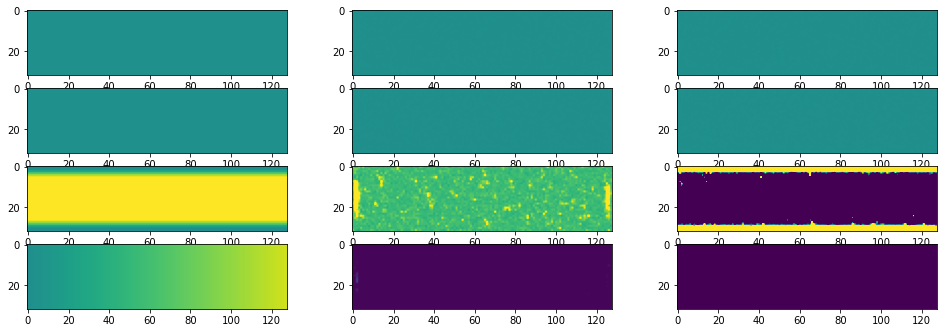

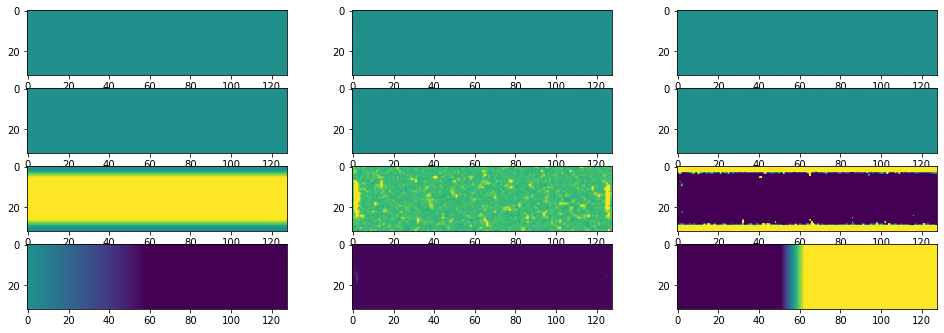

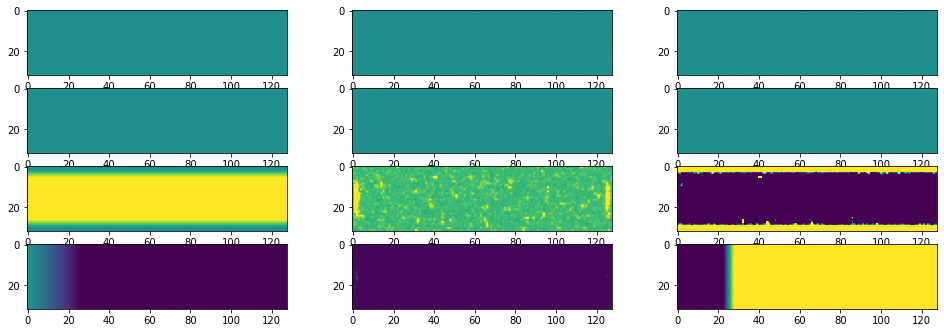

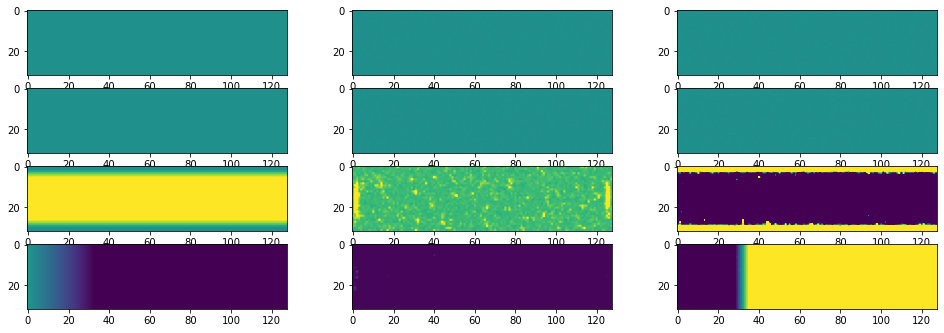

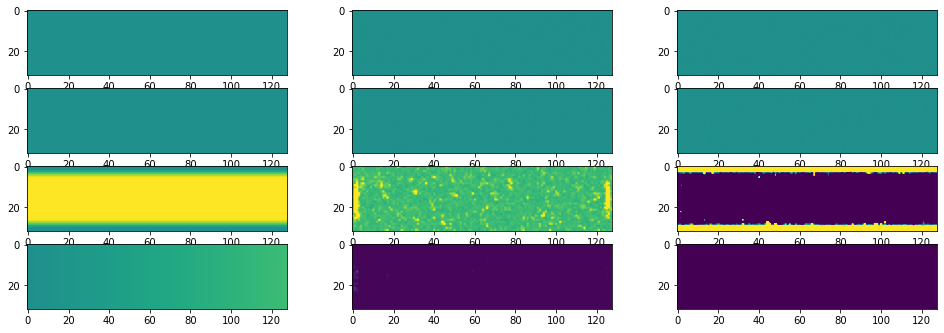

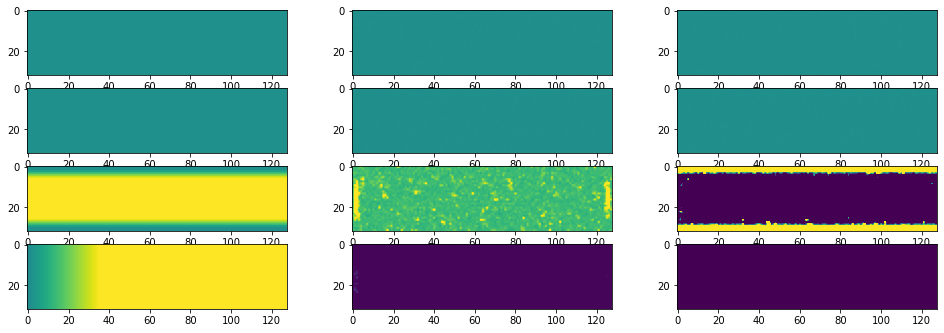

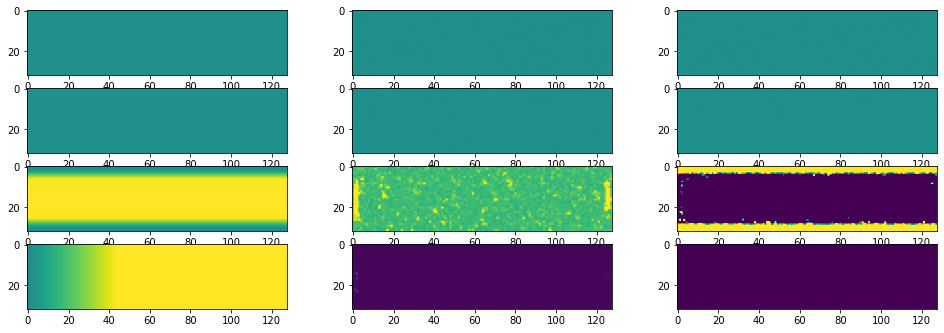

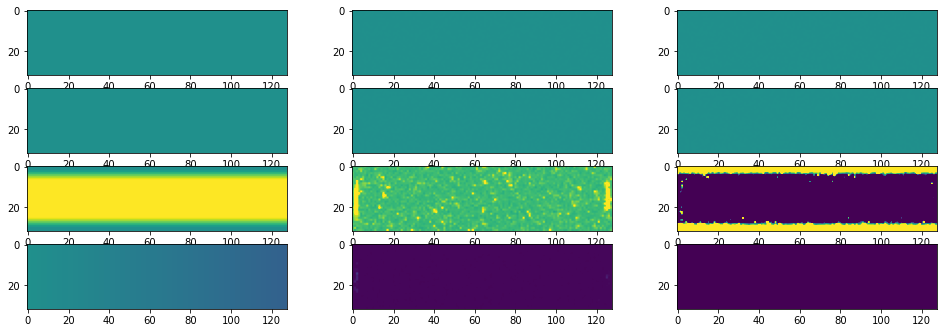

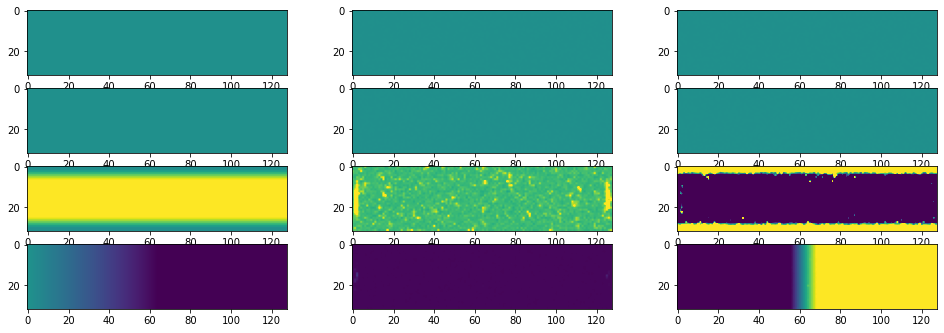

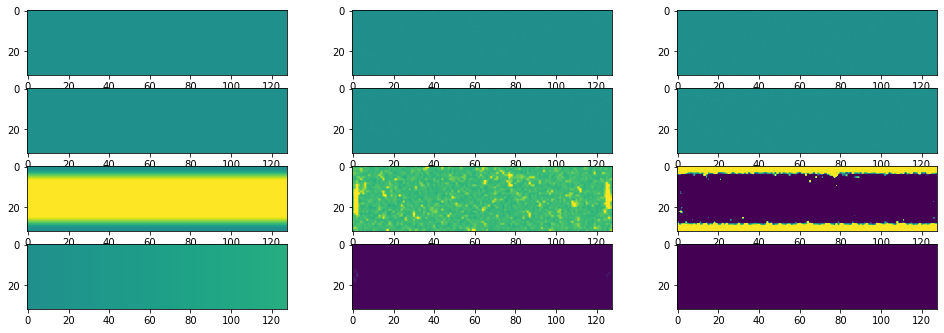

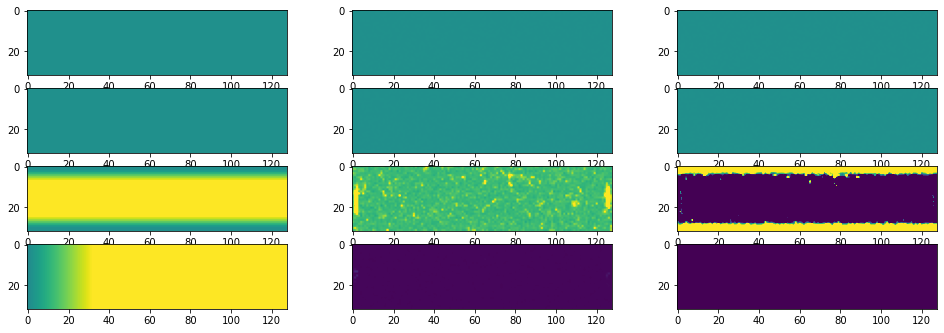

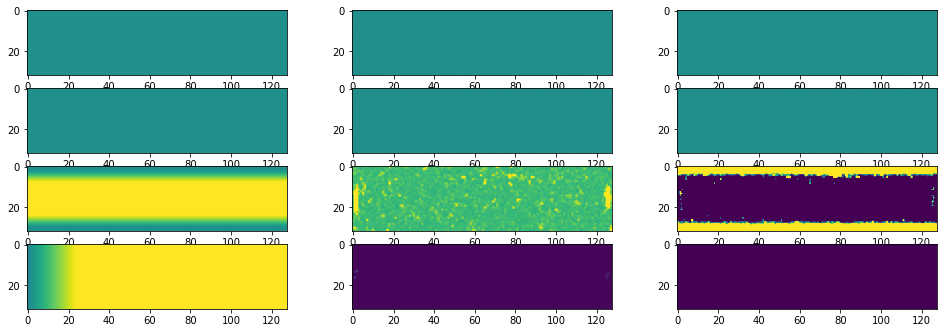

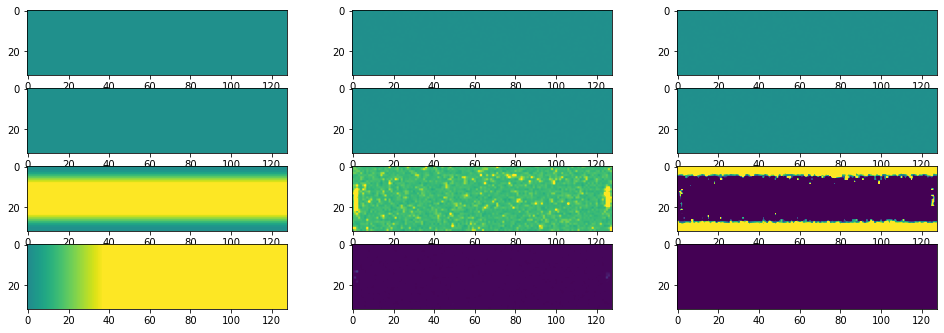

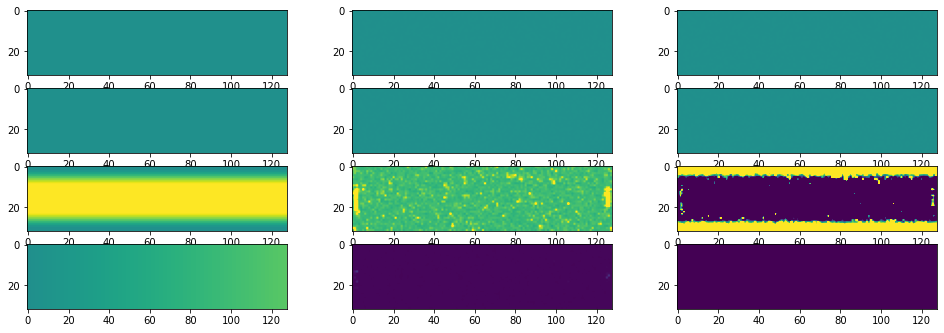

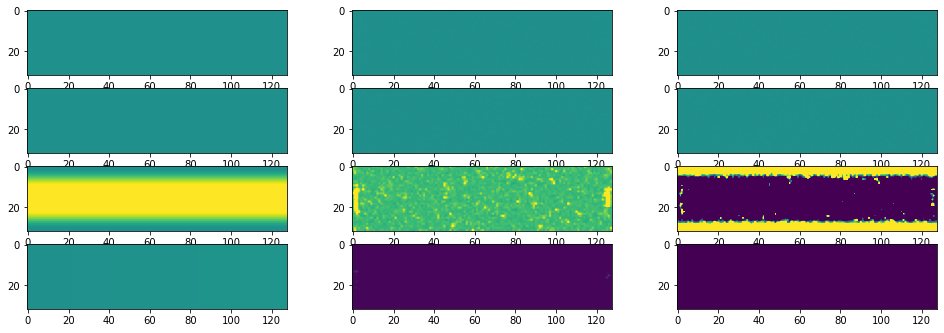

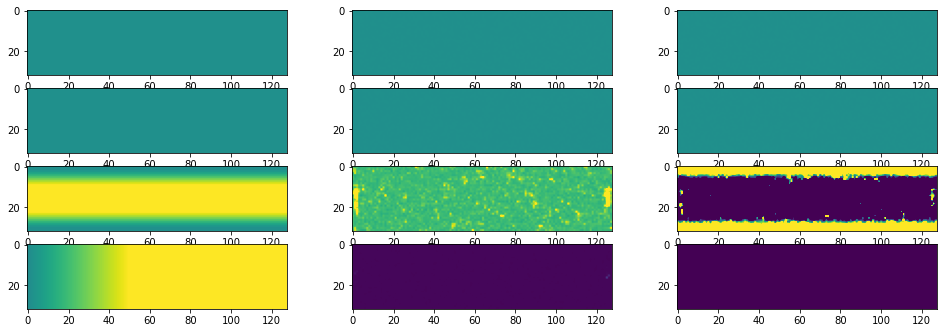

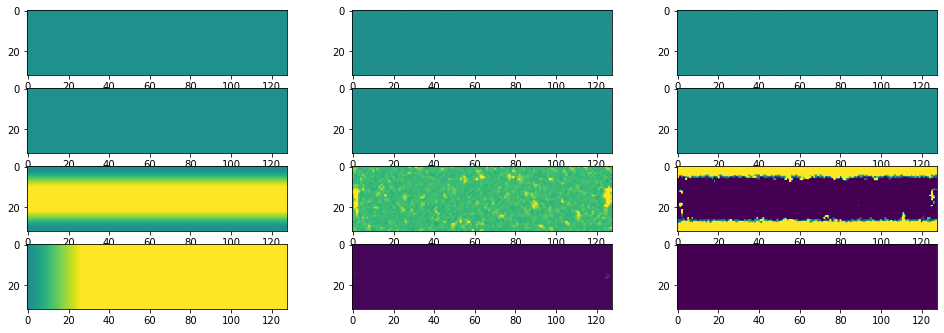

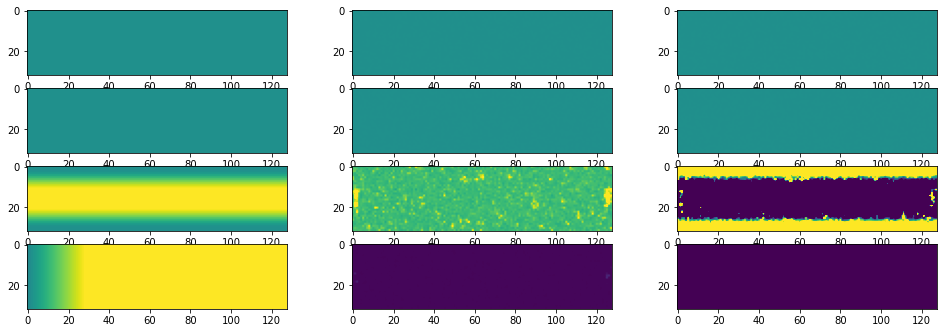

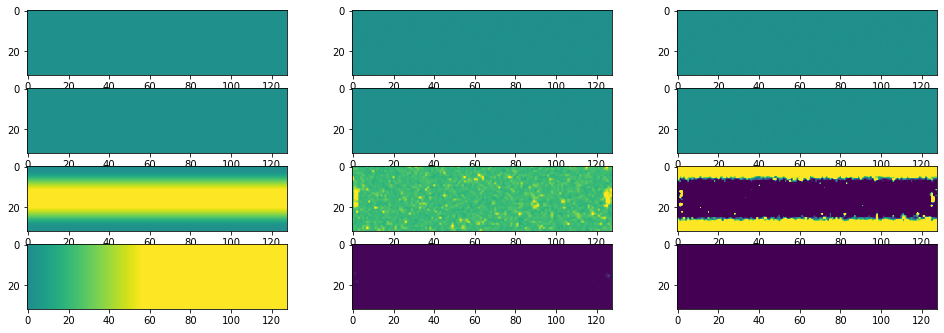

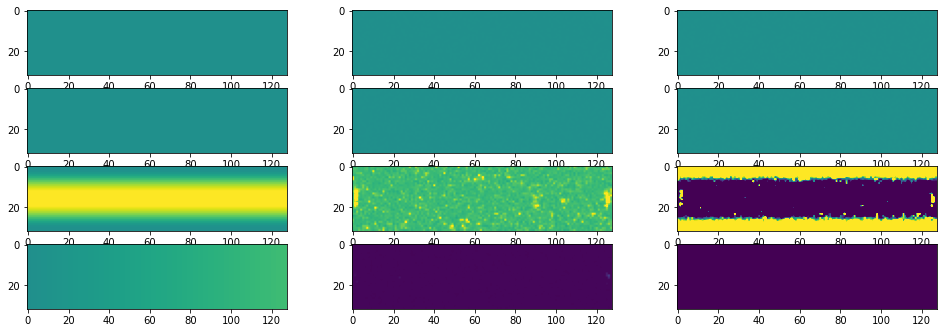

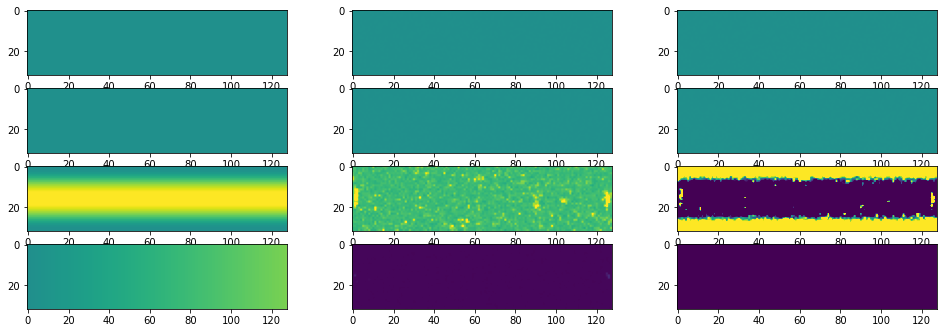

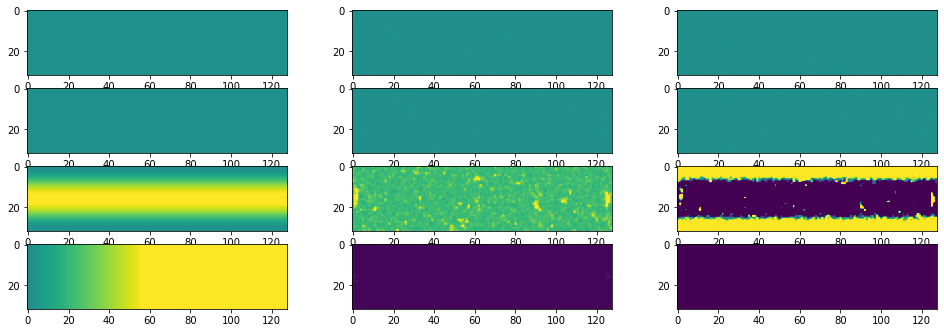

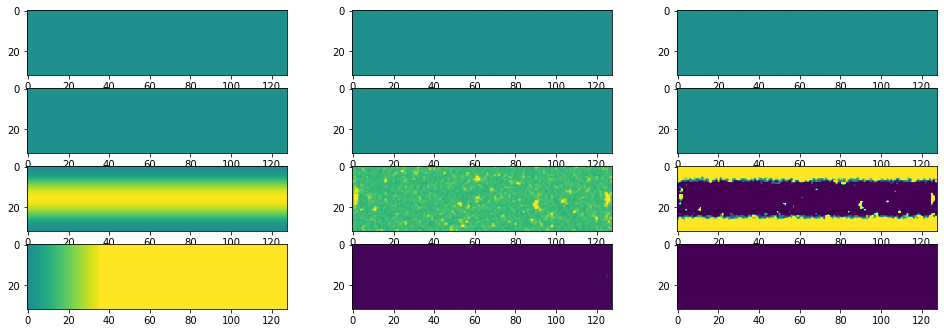

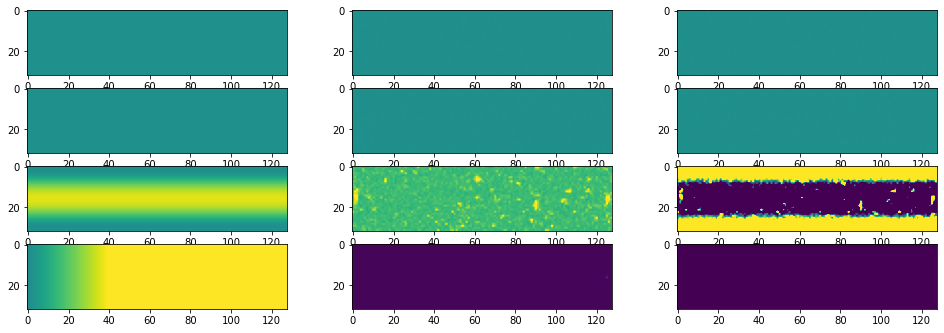

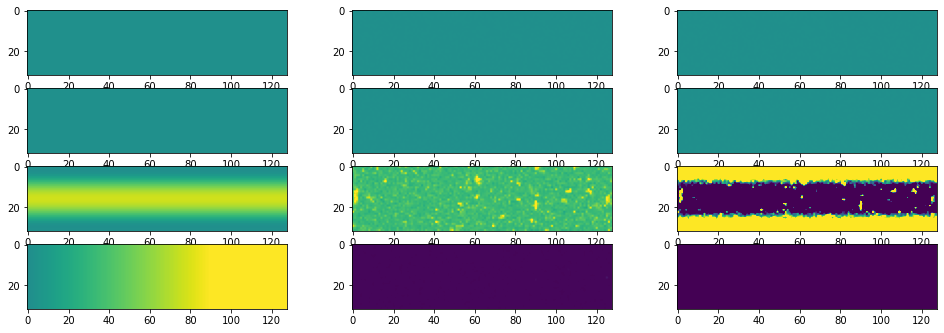

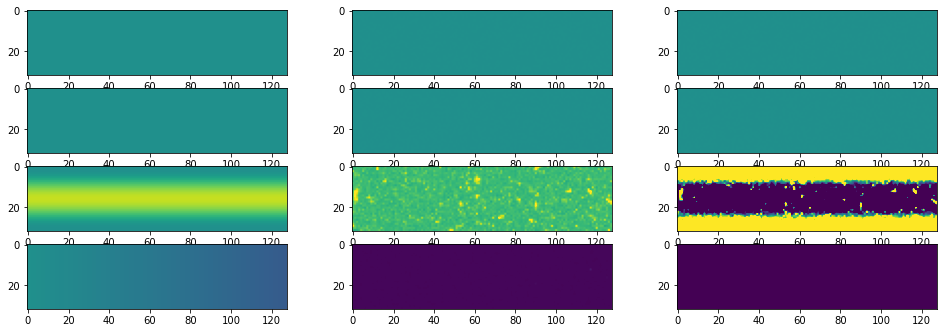

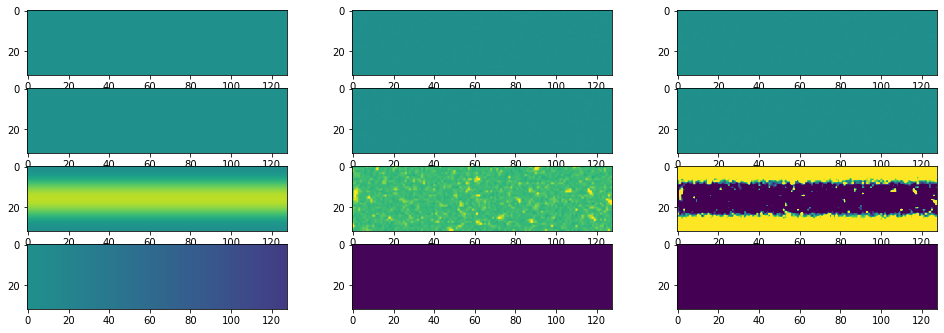

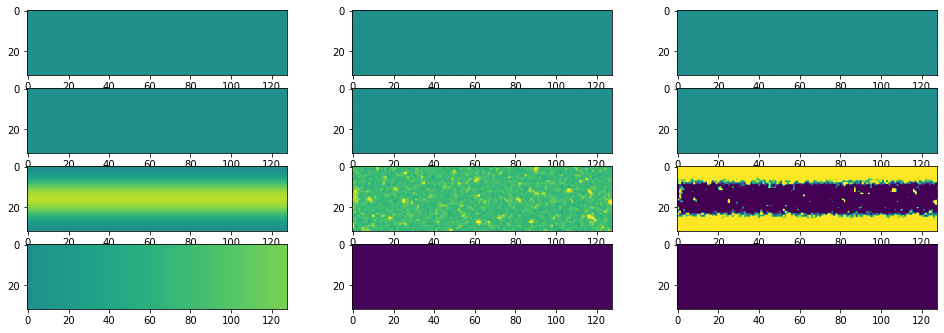

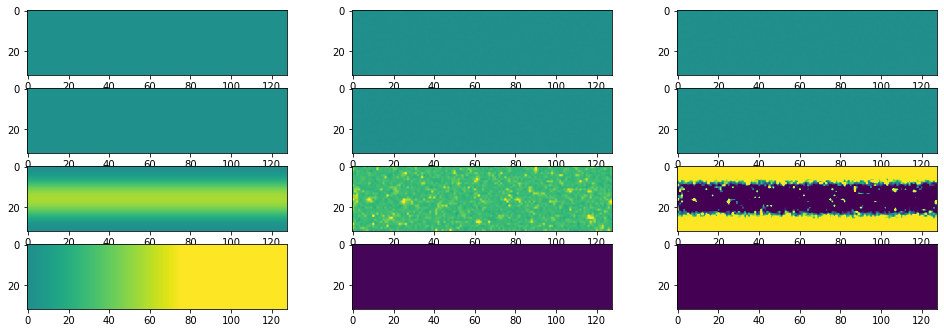

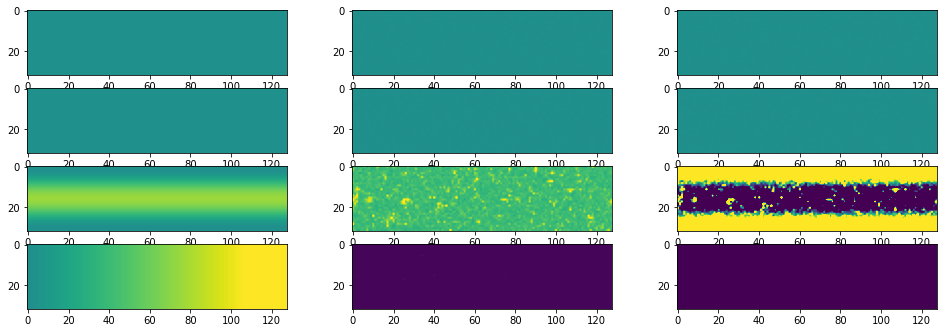

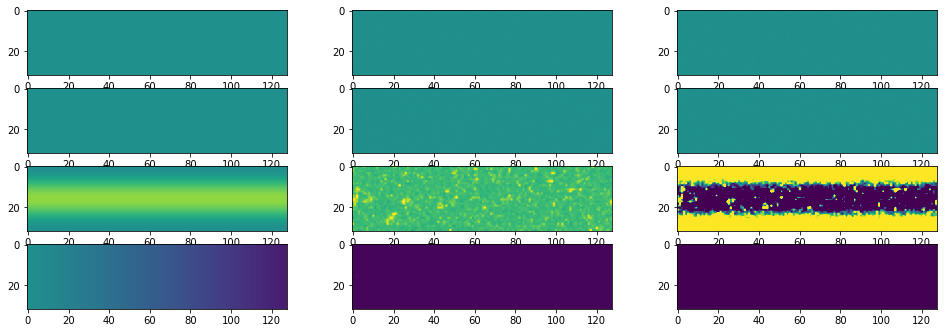

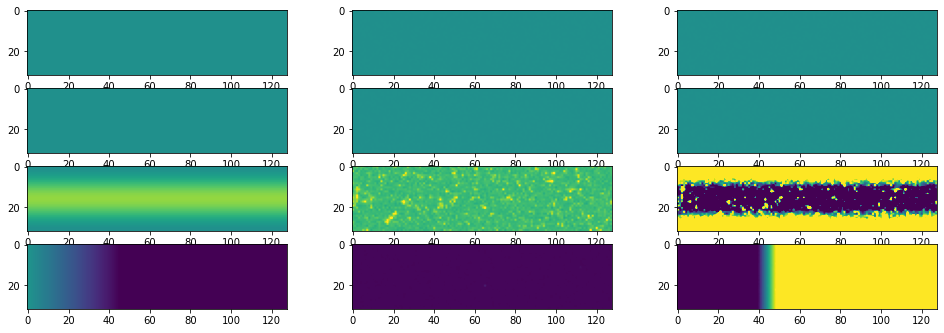

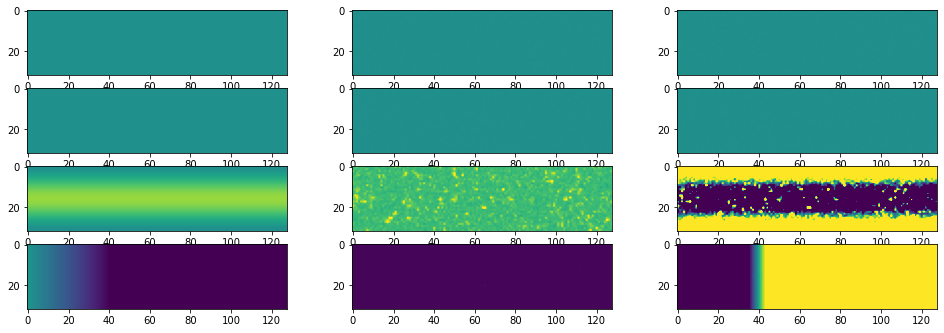

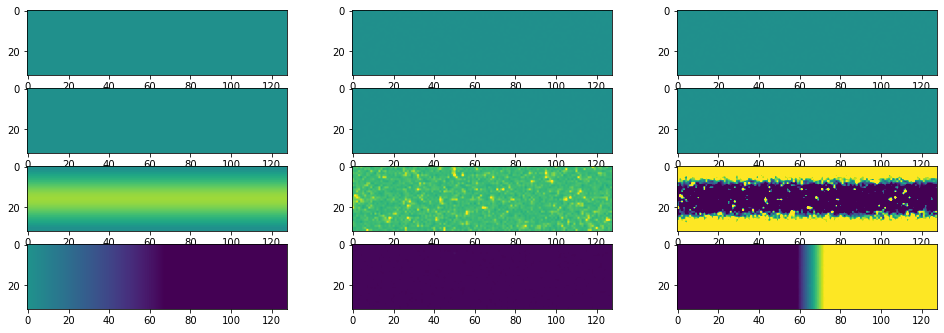

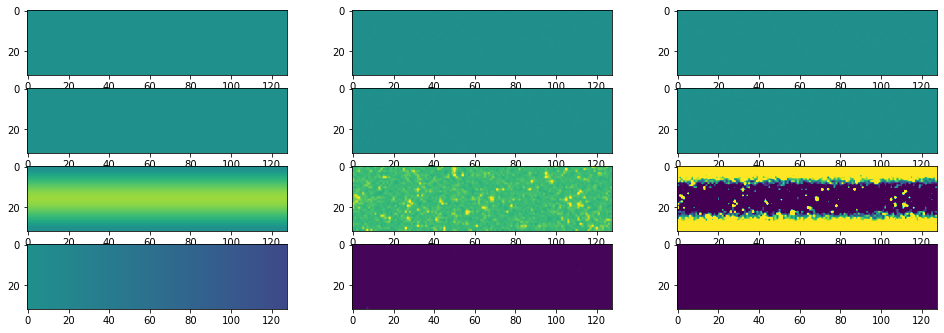

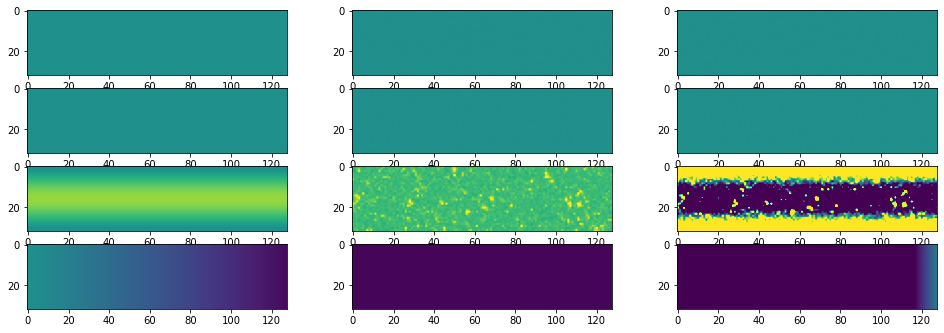

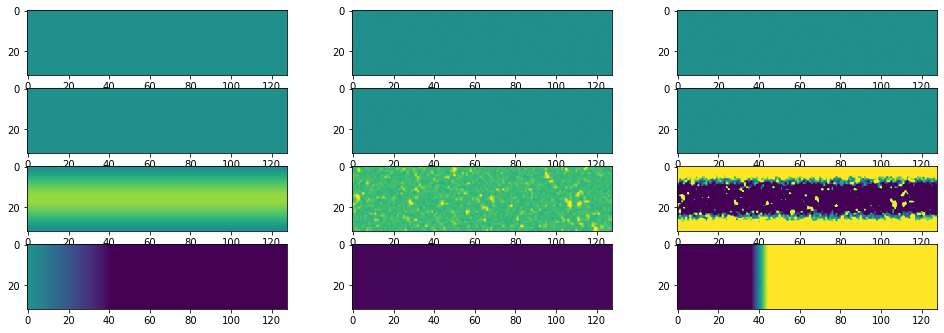

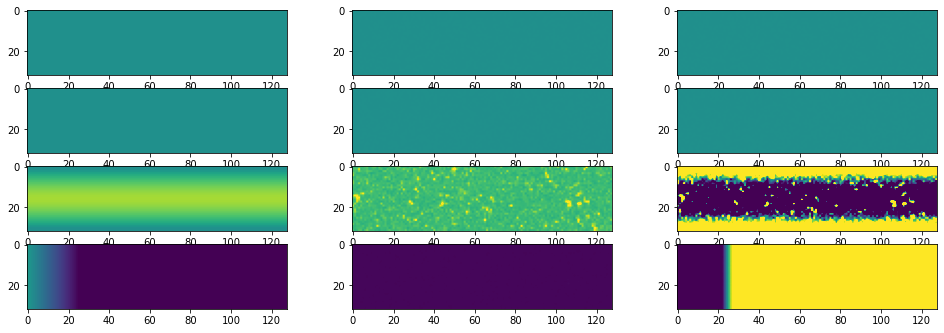

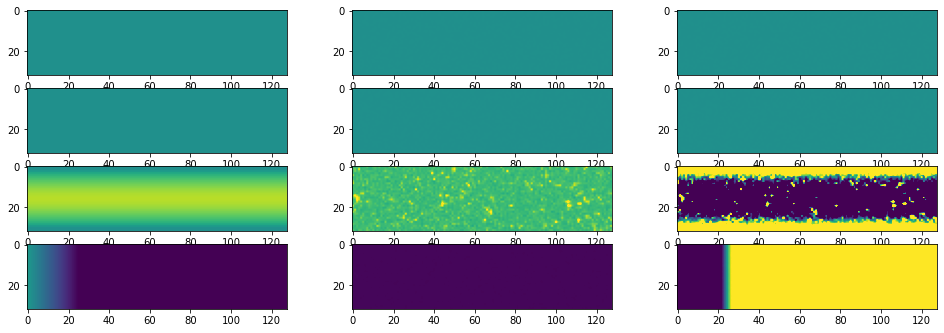

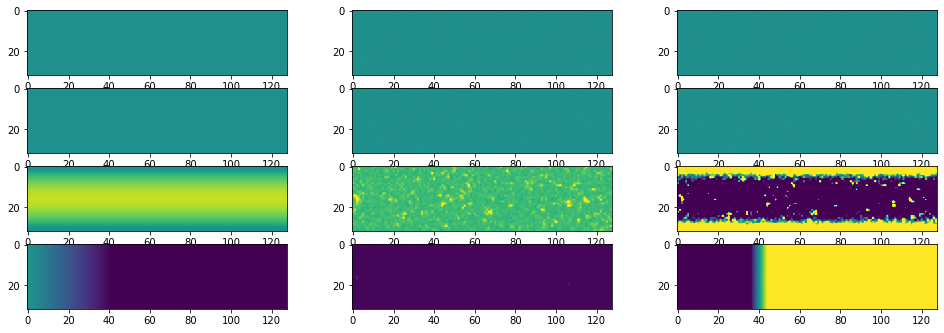

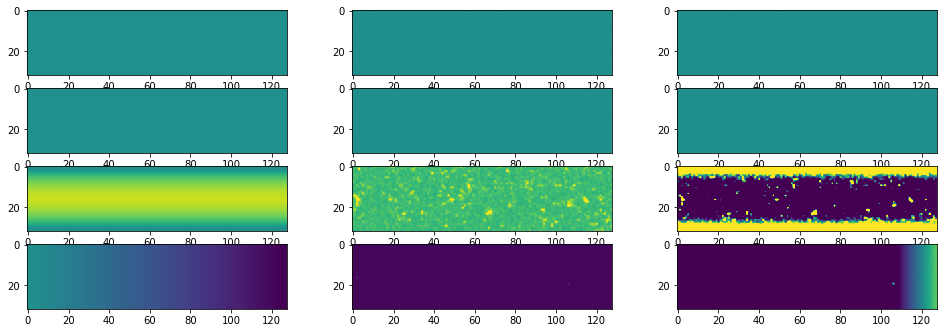

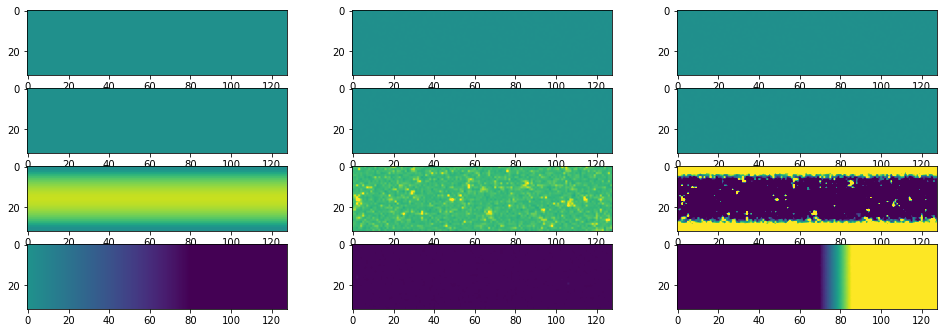

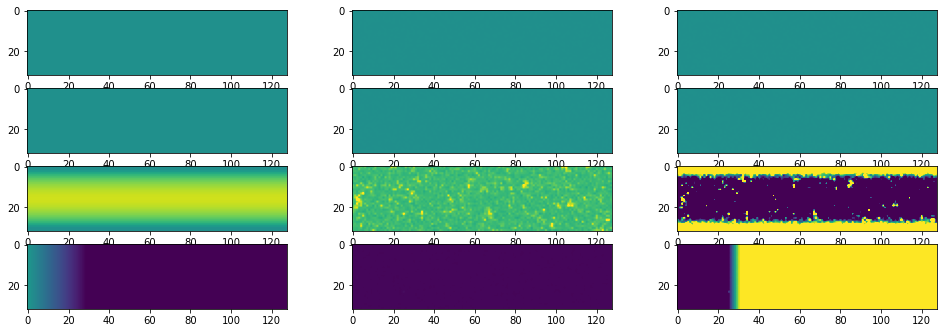

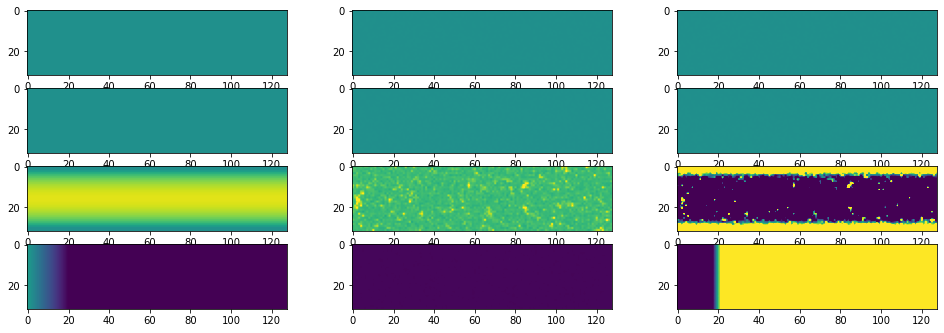

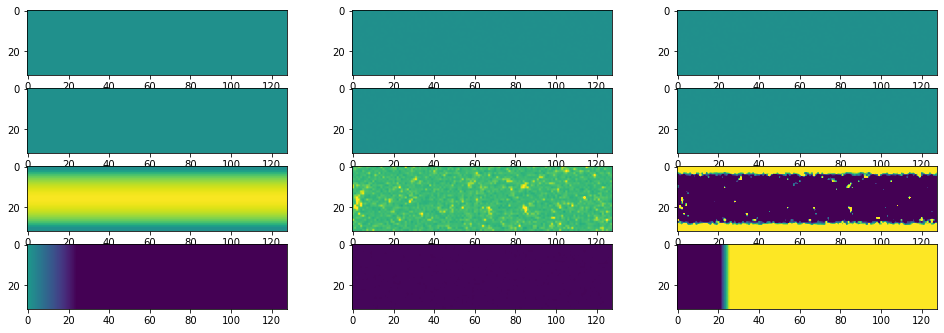

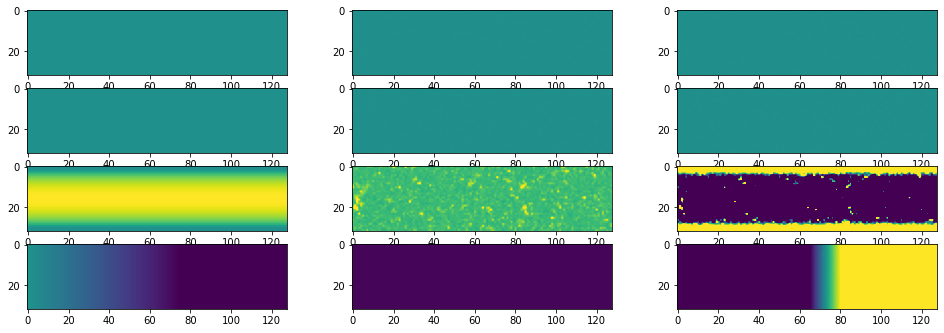

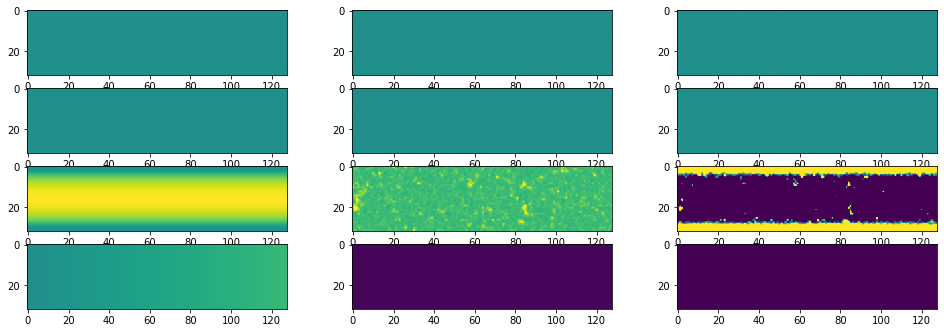

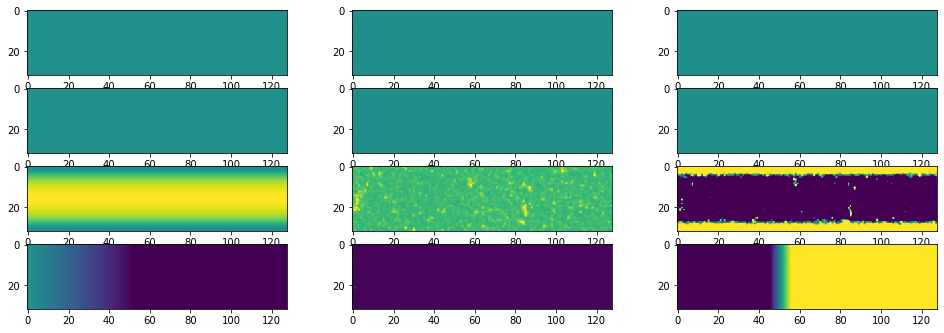

In [13]:
Nxt = 32
Nzt = 4*Nxt
Ntt = 64

xt,yt,zt,tt = np.meshgrid(np.linspace(-1.1,1.1,Nxt),np.linspace(0,0,1),np.linspace(-0.1,8.1,Nzt),np.linspace(0,1,Ntt))
ut,vt,wt = pipe.velocity(xt,yt,zt,tt)
pt = pipe.pressure(xt,yt,zt,tt)
ut = np.squeeze(ut[0,:,:,:])
vt = np.squeeze(vt[0,:,:,:])
wt = np.squeeze(wt[0,:,:,:])
pt = np.squeeze(pt[0,:,:,:])


Xt = np.concatenate((xt.reshape((Nxt*Nzt*Ntt,1)),yt.reshape((Nxt*Nzt*Ntt,1)),zt.reshape((Nxt*Nzt*Ntt,1)),tt.reshape((Nxt*Nzt*Ntt,1))),axis=1)
Xt = torch.from_numpy(Xt).float().cuda()
Fpt = net(Xt)

Fpt = Fpt.cpu().detach().numpy().reshape((Nxt,1,Nzt,Ntt,4))
upt = np.squeeze(Fpt[:,0,:,:,0])
vpt = np.squeeze(Fpt[:,0,:,:,1])
wpt = np.squeeze(Fpt[:,0,:,:,2])
ppt = np.squeeze(Fpt[:,0,:,:,3])
for tn in np.arange(Ntt):
    fig, axes = plt.subplots(4,3, figsize=(16.5,5.5))
    axes[0,0].imshow(ut[:,:,tn],vmin=-1,vmax=1)
    axes[0,1].imshow(upt[:,:,tn],vmin=-1,vmax=1)
    axes[0,2].imshow(upt[:,:,tn]-ut[:,:,tn],vmin=-0.1,vmax=0.1)
    
    axes[1,0].imshow(vt[:,:,tn],vmin=-1,vmax=1)
    axes[1,1].imshow(vpt[:,:,tn],vmin=-1,vmax=1)
    axes[1,2].imshow(vpt[:,:,tn]-vt[:,:,tn],vmin=-0.1,vmax=0.1)
    
    axes[2,0].imshow(wt[:,:,tn],vmin=-1,vmax=1)
    axes[2,1].imshow(wpt[:,:,tn],vmin=-1,vmax=1)
    axes[2,2].imshow(wpt[:,:,tn]-wt[:,:,tn],vmin=-0.1,vmax=0.1)
    
    axes[3,0].imshow(pt[:,:,tn],vmin=-1,vmax=1)
    axes[3,1].imshow(ppt[:,:,tn],vmin=-1,vmax=1)
    axes[3,2].imshow(ppt[:,:,tn]-pt[:,:,tn],vmin=-0.1,vmax=0.1)
    
    
    plt.show()